TED Talks transcripts
https://www.kaggle.com/rounakbanik/ted-talks?select=transcripts.csv#

In [53]:
import pandas as pd
import spacy
import numpy as np
import pickle
import re
from sklearn import svm
from scipy.stats import entropy

from sklearn.metrics import *
from matplotlib import pyplot as plt 
from collections import OrderedDict
import random
import requests

In [2]:
def load_phonetic_embedding():
    lookup = None
    # read phonetic embedding pickle file
    path = "../data/"
    with open(path+'phonetic_embd.pickle', 'rb') as handle:
        lookup = pickle.load(handle)
    print("Phonetic embedding loaded !")
    return lookup

lookup = load_phonetic_embedding()

len(list(lookup.keys()))

Phonetic embedding loaded !


116514

In [158]:
"$" in list(lookup.keys())

False

In [5]:
"NY" in lookup

False

In [28]:
"alaska" in lookup

False

In [6]:
df = pd.read_csv("../data/TED_transcripts.csv")
df = df["transcript"]
df.head()

0    Good morning. How are you?(Laughter)It's been ...
1    Thank you so much, Chris. And it's truly a gre...
2    (Music: "The Sound of Silence," Simon & Garfun...
3    If you're here today — and I'm very happy that...
4    About 10 years ago, I took on the task to teac...
Name: transcript, dtype: object

In [7]:
df.shape

(2467,)

In [9]:
# Tokenize all documents
nlp = spacy.load("en_core_web_sm")

tokens = []
for talk in df:
    doc = nlp(talk)
    words = []
    for w in doc:
        if w.text.isalpha():
            words.append(w.text.lower())
    words = list(set(words))
    tokens.append(words)
print(len(tokens))

2467


In [11]:
# save TED transcript unique tokens to file
with open('TED_transcript_tokens.npy', 'wb') as f:
    np.save(f, np.array(tokens, dtype=object))

In [12]:
# load saved file
tokens = np.load('TED_transcript_tokens.npy', allow_pickle=True)

In [13]:
# set of unique words among all of the test set
test_words = []
for l in tokens:
    test_words.extend(l)
test_words = list(dict.fromkeys(test_words))
len(test_words)

56989

In [14]:
# returns 1 if word is difficult to say 0 otherwise
# here, we have simulated 5 different users so output will be different for each user
def oracle(word, user):
    if user==0:   # starting with a consonant and then followed by the r sound
        pattern = "^([b-df-hj-np-tv-z])r.*"
    elif user==1:  # starting with st or fl
        pattern = "^(st|fl).*"
    elif user==2:  # r or l letter at second place
        pattern = ".{1}[r|l].*"
    elif user==3:  # anywhere in the word - ch or sc
        pattern = ".*(ch|sc).*" 
    elif user==4:  # starting with B,P,D,M,N, and F 
        pattern = "^[bpdmnf].*"
    elif user==5:   # user0 + user4
        pattern = "^([b-df-hj-np-tv-z])r.*" + "|" + "^[bpdmnf].*"
    elif user==6:  # user1 + user3
        pattern = "^(st|fl).*" + "|" + ".*(ch|sc).*"
    elif user==7:  # user2 + user4
        pattern = ".{1}[r|l].*" + "|" + "^[bpdmnf].*"
    elif user==8:  # user0 + user3 + user4
        pattern = "^([b-df-hj-np-tv-z])r.*" +"|"+ ".*(ch|sc).*" + "|" + "^[bpdmnf].*"
    elif user==9:  # user1 + user2 + user3 
        pattern = "^(st|fl).*" + "|" + ".{1}[r|l].*" + "|" + ".*(ch|sc).*"
    m = re.match(pattern, word)
    if m:
        start, stop = m.span()
        if stop-start == len(word):
            return 1
    return 0

In [64]:
oracle("pikacu", 9)

0

In [24]:
oracle("school", 1)

0

In [25]:
def random_sampling(X_unlab, seed):
    random.seed(seed)
    return random.choice(X_unlab)

In [92]:
# returns the next most uncertain word by entropy
# @input: clf - classifier, X_unlab - list of words
def uncertainity_sampling(clf, X_unlab):
    X_unlab = [w for w in X_unlab if w.upper() in lookup]
    X = [lookup[w.upper()] for w in X_unlab]
    prob = clf.predict_proba(X)
    ent = entropy(prob.T)
    sorted_ind = (-ent).argsort()[0]
    return X_unlab[sorted_ind]

def clf_predict(clf, words):
    pred = []
    for w in words:
        w = w.upper()
        if w not in lookup:
            pred.append(0)
        else:
            pred.append(clf.predict([lookup[w]])[0])
    return pred

# fit function because not all words are available in lookup
def clf_fit(words, label):
    X, y = [], []
    for w,l in zip(words, label):
        w = w.upper()
        if w in lookup:
            X.append(lookup[w])
            y.append(l)
    clf = svm.SVC(probability=True, random_state=0, class_weight='balanced')
    clf.fit(X, y)
    return clf

In [93]:
# for a given trained classifier - computes different metrics on the test set
def evaluate(clf, X_test, y_test):
    y_pred = clf_predict(clf, X_test)
    pre = precision_score(y_test, y_pred, zero_division=0)*100
    acc = accuracy_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    #print(round(f1,2), "   ",round(acc,2), "    ",round(pre,2))
    return {"precision":pre, "accuracy":acc, "f1":f1, "recall":recall}

In [94]:
def initial_split(i):
    easy, diff = [], []
    #easy = ['a', 'an', 'he', 'she', 'be', 'the', 'cat', 'dog', 'bat', 'mat', 'rat']
    if i==0:   # r sound at second place
        #print("consonant followed by r sound")
        easy = ['clock', 'regular', 'water', 'made']
        diff = ['graph', 'group', 'green', 'grand']
    elif i==1: # st or fl sound to begin
        #print("st or fl sound to begin")
        easy = ['the', 'cat', 'dog', 'bat']
        diff = ['street', 'florida', 'straight', 'stutter']
    elif i==2:     # r or l letter at second place
        #print("r or l letter at second place")
        easy = ['about', 'people', 'day', 'other']
        diff = ['crisp', 'crumble', 'alaska', 'close']
    elif i==3:   # ch or sc sound anywhere in the word
        #print("sc or ch sound anywhere in the word")
        easy = ['book', 'table', 'cat', 'shirt']
        diff = ['scold', 'chair', 'beach', 'chase']
    elif i==4:  # words starting with B,P,D,M,N, and F
        #print("words starting with B,P,D,M,N, and F")
        easy = ['horse', 'house', 'group', 'actor']
        diff = ['packet', 'more', 'nostalgia', 'fish']
    elif i==5:   # user0 + user4
        #print("consonant followed by r sound +  words starting with B,P,D,M,N, and F")
        easy = ['racket', 'choice', 'egg', 'active']
        diff = ['crime', 'provost', 'post', 'dragon']
    elif i==6: # user1 + user3
        #print("st or fl sound to begin +  sc or ch sound anywhere in the word")
        easy = ['packet', 'more', 'nostalgia', 'fish']
        diff = ['flood', 'scandal', 'stay', 'choke']
    elif i==7:     # user2 + user4
        #print("r or l letter at second place  +  words starting with B,P,D,M,N, and F")
        easy = ['cook', 'table', 'cat', 'she']
        diff = ['graph', 'alcohol', 'ball','market']
    elif i==8:   # user0 + user3 + user4
        #print("consonant followed by r sound + sc or ch sound anywhere + starting with B,P,D,M,N, and F")
        easy = ['rational', 'recommend', 'circle', 'gang']
        diff = ['scam', 'grand', 'match', 'cheese']
    elif i==9:  # user1 + user2 + user3 
        #print("st or fl sound to begin + r or l letter at second place + sc or ch sound anywhere in the word")
        easy = ['beauty', 'pen', 'dish', 'govern']
        diff = ['match', 'scam', 'alcohol', 'scold']
    #diff = ['graph', 'group', 'trivedi', 'green', 'grand', 'provost', 'crisp', 'grey', 'grill', 'crumble']

    X_lab = easy + diff
    y_lab = [0]*len(easy) + [1]*len(diff)

    X_rem = list(set(test_words) - set(X_lab))

    test_size = int(len(X_rem)*0.25)
    
    X_test = X_rem[len(X_rem)-test_size:]
    y_test = [oracle(w, i) for w in X_test]
    
    X_unlab = X_rem[:len(X_rem)-test_size]
    X_train = X_lab + X_unlab

    #print(len(X_lab), len(X_unlab), len(X_train), len(X_test))
    
    return X_lab, y_lab, X_unlab, X_test, y_test

In [95]:
# check if all seed words exist in phonetic dictionary
# and they are assigned correct labels
for i in range(10):
    print(i)
    word, y_label = initial_split(i)[0], initial_split(i)[1]
    for w in word:
        if w.upper() not in lookup:
            print(w + " NOT PRESENT")
    
    if y_label != [0, 0, 0, 0, 1, 1, 1, 1]:
        print("Label not matching for user: ",i)

0
1
2
3
4
5
6
7
8
9


In [144]:
# get most suitable alterantive for word which user can speak
def get_alternative(word, user_id):
    try:
        response = requests.get("https://api.datamuse.com/words?ml="+word)
    except JSONDecodeError as e:
        print("Exception")
    else:
        for l in response.json():
            s = l["word"] 
            if s.upper() in lookup and oracle(s, user_id)==0:
                return s
    return ""

In [147]:
get_alternative("alaska", 2)

'barcelona'

In [148]:
get_alternative("rocketcam", 0)

''

In [149]:
res = {"imp":[], "exp":[], "ran":[]} 

number_of_queries = 500
rounds = 10

for r in range(rounds):
    print("\n\nRound ", r)
    for strategy in ["exp","imp","ran"]:  # 
        X_lab, y_lab, X_unlab, X_test, y_test = initial_split(r)
        model = clf_fit(X_lab, y_lab)
        #res[strategy][r] = []
        res[strategy].append(evaluate(model, X_test, y_test))
        print("******    "+strategy+"    ********")

        for i in range(number_of_queries):
                q = []
                if strategy=="imp":
                    # adding the next word and its suitable alternative
                    q.append(X_unlab[0])
                    alter = get_alternative(X_unlab[0], r)
                    if len(alter)>0:
                        q.append(alter)
                elif strategy=="exp":
                    q.append(uncertainity_sampling(model, X_unlab))
                elif strategy=="ran":
                    q.append(random_sampling(X_unlab, r*i))
                
                X_lab.extend(q)
                # for each word in q, append its label
                for t in q:  
                    y_lab.append(oracle(t, r))
                
                X_unlab = list(set(X_unlab)-set(q))
                model = clf_fit(X_lab, y_lab)
                print("Query: ", i+1, " word: ", q[0], "  label: ",oracle(q[0], r), "len X_lab: ", len(X_lab))
                res[strategy].append(evaluate(model, X_test, y_test))    



Round  0
******    exp    ********
Query:  1  word:  humiliating   label:  0 len X_lab:  9
Query:  2  word:  kremer   label:  1 len X_lab:  10
Query:  3  word:  braves   label:  1 len X_lab:  11
Query:  4  word:  afresh   label:  0 len X_lab:  12
Query:  5  word:  kresge   label:  1 len X_lab:  13
Query:  6  word:  grieve   label:  1 len X_lab:  14
Query:  7  word:  geese   label:  0 len X_lab:  15
Query:  8  word:  monograph   label:  0 len X_lab:  16
Query:  9  word:  bret   label:  1 len X_lab:  17
Query:  10  word:  british   label:  1 len X_lab:  18
Query:  11  word:  expands   label:  0 len X_lab:  19
Query:  12  word:  blake   label:  0 len X_lab:  20
Query:  13  word:  bragg   label:  1 len X_lab:  21
Query:  14  word:  blinds   label:  0 len X_lab:  22
Query:  15  word:  brinker   label:  1 len X_lab:  23
Query:  16  word:  canary   label:  0 len X_lab:  24
Query:  17  word:  crush   label:  1 len X_lab:  25
Query:  18  word:  prime   label:  1 len X_lab:  26
Query:  19  wor

Query:  149  word:  tharp   label:  0 len X_lab:  157
Query:  150  word:  fragrance   label:  1 len X_lab:  158
Query:  151  word:  progeny   label:  1 len X_lab:  159
Query:  152  word:  posted   label:  0 len X_lab:  160
Query:  153  word:  provincial   label:  1 len X_lab:  161
Query:  154  word:  privatization   label:  1 len X_lab:  162
Query:  155  word:  drones   label:  1 len X_lab:  163
Query:  156  word:  truancy   label:  1 len X_lab:  164
Query:  157  word:  gearing   label:  0 len X_lab:  165
Query:  158  word:  bunny   label:  0 len X_lab:  166
Query:  159  word:  prattle   label:  1 len X_lab:  167
Query:  160  word:  craving   label:  1 len X_lab:  168
Query:  161  word:  neurosurgery   label:  0 len X_lab:  169
Query:  162  word:  procured   label:  1 len X_lab:  170
Query:  163  word:  sprinting   label:  0 len X_lab:  171
Query:  164  word:  trek   label:  1 len X_lab:  172
Query:  165  word:  brightening   label:  1 len X_lab:  173
Query:  166  word:  trekked   labe

Query:  293  word:  predicated   label:  1 len X_lab:  301
Query:  294  word:  gravitationally   label:  1 len X_lab:  302
Query:  295  word:  freak   label:  1 len X_lab:  303
Query:  296  word:  coventry   label:  0 len X_lab:  304
Query:  297  word:  bulgarians   label:  0 len X_lab:  305
Query:  298  word:  trillion   label:  1 len X_lab:  306
Query:  299  word:  strasbourg   label:  0 len X_lab:  307
Query:  300  word:  properly   label:  1 len X_lab:  308
Query:  301  word:  pickling   label:  0 len X_lab:  309
Query:  302  word:  frey   label:  1 len X_lab:  310
Query:  303  word:  drapery   label:  1 len X_lab:  311
Query:  304  word:  curators   label:  0 len X_lab:  312
Query:  305  word:  credited   label:  1 len X_lab:  313
Query:  306  word:  drexler   label:  1 len X_lab:  314
Query:  307  word:  confronts   label:  0 len X_lab:  315
Query:  308  word:  strands   label:  0 len X_lab:  316
Query:  309  word:  brockington   label:  1 len X_lab:  317
Query:  310  word:  paro

Query:  436  word:  lafrance   label:  0 len X_lab:  444
Query:  437  word:  craftsmanship   label:  1 len X_lab:  445
Query:  438  word:  proselytizing   label:  1 len X_lab:  446
Query:  439  word:  unproductive   label:  0 len X_lab:  447
Query:  440  word:  christianity   label:  0 len X_lab:  448
Query:  441  word:  cambria   label:  0 len X_lab:  449
Query:  442  word:  shrub   label:  0 len X_lab:  450
Query:  443  word:  beers   label:  0 len X_lab:  451
Query:  444  word:  telegram   label:  0 len X_lab:  452
Query:  445  word:  trucked   label:  1 len X_lab:  453
Query:  446  word:  treacherous   label:  1 len X_lab:  454
Query:  447  word:  purest   label:  0 len X_lab:  455
Query:  448  word:  fritz   label:  1 len X_lab:  456
Query:  449  word:  scrapers   label:  0 len X_lab:  457
Query:  450  word:  drainage   label:  1 len X_lab:  458
Query:  451  word:  prophylactic   label:  1 len X_lab:  459
Query:  452  word:  trappist   label:  1 len X_lab:  460
Query:  453  word: 

Query:  81  word:  pearly   label:  0 len X_lab:  154
Query:  82  word:  registers   label:  0 len X_lab:  156
Query:  83  word:  sarandon   label:  0 len X_lab:  158
Query:  84  word:  injustice   label:  0 len X_lab:  160
Query:  85  word:  awol   label:  0 len X_lab:  162
Query:  86  word:  governing   label:  0 len X_lab:  164
Query:  87  word:  als   label:  0 len X_lab:  166
Query:  88  word:  milo   label:  0 len X_lab:  168
Query:  89  word:  consigned   label:  0 len X_lab:  170
Query:  90  word:  pooper   label:  0 len X_lab:  172
Query:  91  word:  mos   label:  0 len X_lab:  174
Query:  92  word:  repugnant   label:  0 len X_lab:  176
Query:  93  word:  decompress   label:  0 len X_lab:  178
Query:  94  word:  coauthors   label:  0 len X_lab:  180
Query:  95  word:  postman   label:  0 len X_lab:  182
Query:  96  word:  flooded   label:  0 len X_lab:  184
Query:  97  word:  saddles   label:  0 len X_lab:  186
Query:  98  word:  inducted   label:  0 len X_lab:  188
Query:  9

Query:  226  word:  carski   label:  0 len X_lab:  427
Query:  227  word:  victrola   label:  0 len X_lab:  429
Query:  228  word:  transmitting   label:  1 len X_lab:  431
Query:  229  word:  anarchist   label:  0 len X_lab:  433
Query:  230  word:  credible   label:  1 len X_lab:  435
Query:  231  word:  encounter   label:  0 len X_lab:  437
Query:  232  word:  swarovski   label:  0 len X_lab:  438
Query:  233  word:  extracellular   label:  0 len X_lab:  440
Query:  234  word:  communism   label:  0 len X_lab:  442
Query:  235  word:  premeditation   label:  1 len X_lab:  444
Query:  236  word:  certainties   label:  0 len X_lab:  446
Query:  237  word:  rupee   label:  0 len X_lab:  448
Query:  238  word:  battlefields   label:  0 len X_lab:  450
Query:  239  word:  evaluations   label:  0 len X_lab:  452
Query:  240  word:  plastering   label:  0 len X_lab:  454
Query:  241  word:  straighter   label:  0 len X_lab:  456
Query:  242  word:  sexologists   label:  0 len X_lab:  458
Q

Query:  370  word:  cornish   label:  0 len X_lab:  701
Query:  371  word:  sheds   label:  0 len X_lab:  703
Query:  372  word:  encrypt   label:  0 len X_lab:  705
Query:  373  word:  grandparent   label:  1 len X_lab:  707
Query:  374  word:  rafidah   label:  0 len X_lab:  708
Query:  375  word:  aravena   label:  0 len X_lab:  709
Query:  376  word:  mckie   label:  0 len X_lab:  711
Query:  377  word:  unscrambling   label:  0 len X_lab:  713
Query:  378  word:  root   label:  0 len X_lab:  715
Query:  379  word:  devoured   label:  0 len X_lab:  717
Query:  380  word:  tollbooths   label:  0 len X_lab:  719
Query:  381  word:  resonates   label:  0 len X_lab:  721
Query:  382  word:  originals   label:  0 len X_lab:  723
Query:  383  word:  unheated   label:  0 len X_lab:  725
Query:  384  word:  translating   label:  1 len X_lab:  727
Query:  385  word:  albertopolis   label:  0 len X_lab:  728
Query:  386  word:  kohl   label:  0 len X_lab:  730
Query:  387  word:  nicely   la

Query:  15  word:  entangling   label:  0 len X_lab:  23
Query:  16  word:  revolt   label:  0 len X_lab:  24
Query:  17  word:  uyghurs   label:  0 len X_lab:  25
Query:  18  word:  behemoth   label:  0 len X_lab:  26
Query:  19  word:  persinger   label:  0 len X_lab:  27
Query:  20  word:  intriguing   label:  0 len X_lab:  28
Query:  21  word:  silences   label:  0 len X_lab:  29
Query:  22  word:  gerrard   label:  0 len X_lab:  30
Query:  23  word:  antonyms   label:  0 len X_lab:  31
Query:  24  word:  viliki   label:  0 len X_lab:  32
Query:  25  word:  meet   label:  0 len X_lab:  33
Query:  26  word:  tensile   label:  0 len X_lab:  34
Query:  27  word:  jong   label:  0 len X_lab:  35
Query:  28  word:  postconflict   label:  0 len X_lab:  36
Query:  29  word:  craze   label:  1 len X_lab:  37
Query:  30  word:  modems   label:  0 len X_lab:  38
Query:  31  word:  supersymmetry   label:  0 len X_lab:  39
Query:  32  word:  disrupts   label:  0 len X_lab:  40
Query:  33  word

Query:  163  word:  laliberté   label:  0 len X_lab:  171
Query:  164  word:  seigniorage   label:  0 len X_lab:  172
Query:  165  word:  bookstores   label:  0 len X_lab:  173
Query:  166  word:  unburden   label:  0 len X_lab:  174
Query:  167  word:  overboard   label:  0 len X_lab:  175
Query:  168  word:  toughen   label:  0 len X_lab:  176
Query:  169  word:  competing   label:  0 len X_lab:  177
Query:  170  word:  swimmers   label:  0 len X_lab:  178
Query:  171  word:  kyi   label:  0 len X_lab:  179
Query:  172  word:  gmo   label:  0 len X_lab:  180
Query:  173  word:  technologyland   label:  0 len X_lab:  181
Query:  174  word:  scoots   label:  0 len X_lab:  182
Query:  175  word:  exerted   label:  0 len X_lab:  183
Query:  176  word:  jambo   label:  0 len X_lab:  184
Query:  177  word:  displaced   label:  0 len X_lab:  185
Query:  178  word:  explores   label:  0 len X_lab:  186
Query:  179  word:  cargos   label:  0 len X_lab:  187
Query:  180  word:  summum   label:

Query:  307  word:  immunogenicity   label:  0 len X_lab:  315
Query:  308  word:  comically   label:  0 len X_lab:  316
Query:  309  word:  fs   label:  0 len X_lab:  317
Query:  310  word:  knighted   label:  0 len X_lab:  318
Query:  311  word:  bornean   label:  0 len X_lab:  319
Query:  312  word:  benoit   label:  0 len X_lab:  320
Query:  313  word:  discs   label:  0 len X_lab:  321
Query:  314  word:  mollycoddle   label:  0 len X_lab:  322
Query:  315  word:  jovian   label:  0 len X_lab:  323
Query:  316  word:  lamenting   label:  0 len X_lab:  324
Query:  317  word:  disassembly   label:  0 len X_lab:  325
Query:  318  word:  teammate   label:  0 len X_lab:  326
Query:  319  word:  metafictive   label:  0 len X_lab:  327
Query:  320  word:  miliband   label:  0 len X_lab:  328
Query:  321  word:  fussing   label:  0 len X_lab:  329
Query:  322  word:  bulletin   label:  0 len X_lab:  330
Query:  323  word:  undone   label:  0 len X_lab:  331
Query:  324  word:  guarding   

Query:  450  word:  zahira   label:  0 len X_lab:  458
Query:  451  word:  implausible   label:  0 len X_lab:  459
Query:  452  word:  beloit   label:  0 len X_lab:  460
Query:  453  word:  beautifully   label:  0 len X_lab:  461
Query:  454  word:  draped   label:  1 len X_lab:  462
Query:  455  word:  picnic   label:  0 len X_lab:  463
Query:  456  word:  sligo   label:  0 len X_lab:  464
Query:  457  word:  valentino   label:  0 len X_lab:  465
Query:  458  word:  elation   label:  0 len X_lab:  466
Query:  459  word:  lang   label:  0 len X_lab:  467
Query:  460  word:  least   label:  0 len X_lab:  468
Query:  461  word:  monochromes   label:  0 len X_lab:  469
Query:  462  word:  socialization   label:  0 len X_lab:  470
Query:  463  word:  affidavit   label:  0 len X_lab:  471
Query:  464  word:  newington   label:  0 len X_lab:  472
Query:  465  word:  municipal   label:  0 len X_lab:  473
Query:  466  word:  militating   label:  0 len X_lab:  474
Query:  467  word:  filed   la

Query:  98  word:  stopped   label:  1 len X_lab:  106
Query:  99  word:  stronger   label:  1 len X_lab:  107
Query:  100  word:  strays   label:  1 len X_lab:  108
Query:  101  word:  strategy   label:  1 len X_lab:  109
Query:  102  word:  sternness   label:  1 len X_lab:  110
Query:  103  word:  shunts   label:  0 len X_lab:  111
Query:  104  word:  napster   label:  0 len X_lab:  112
Query:  105  word:  standardize   label:  1 len X_lab:  113
Query:  106  word:  strategies   label:  1 len X_lab:  114
Query:  107  word:  styrene   label:  1 len X_lab:  115
Query:  108  word:  restructures   label:  0 len X_lab:  116
Query:  109  word:  staccato   label:  1 len X_lab:  117
Query:  110  word:  sistine   label:  0 len X_lab:  118
Query:  111  word:  stupider   label:  1 len X_lab:  119
Query:  112  word:  libido   label:  0 len X_lab:  120
Query:  113  word:  chiding   label:  0 len X_lab:  121
Query:  114  word:  strife   label:  1 len X_lab:  122
Query:  115  word:  sweets   label: 

Query:  243  word:  straus   label:  1 len X_lab:  251
Query:  244  word:  storyteller   label:  1 len X_lab:  252
Query:  245  word:  scaffolds   label:  0 len X_lab:  253
Query:  246  word:  stuff   label:  1 len X_lab:  254
Query:  247  word:  shoots   label:  0 len X_lab:  255
Query:  248  word:  stutzman   label:  1 len X_lab:  256
Query:  249  word:  slandered   label:  0 len X_lab:  257
Query:  250  word:  slots   label:  0 len X_lab:  258
Query:  251  word:  astride   label:  0 len X_lab:  259
Query:  252  word:  scarring   label:  0 len X_lab:  260
Query:  253  word:  stinking   label:  1 len X_lab:  261
Query:  254  word:  doorstep   label:  0 len X_lab:  262
Query:  255  word:  roadster   label:  0 len X_lab:  263
Query:  256  word:  forestry   label:  0 len X_lab:  264
Query:  257  word:  snaking   label:  0 len X_lab:  265
Query:  258  word:  stimulative   label:  1 len X_lab:  266
Query:  259  word:  scarcity   label:  0 len X_lab:  267
Query:  260  word:  slimmest   labe

Query:  387  word:  toasting   label:  0 len X_lab:  395
Query:  388  word:  stockholm   label:  1 len X_lab:  396
Query:  389  word:  stradivarius   label:  1 len X_lab:  397
Query:  390  word:  figments   label:  0 len X_lab:  398
Query:  391  word:  spartans   label:  0 len X_lab:  399
Query:  392  word:  substitutes   label:  0 len X_lab:  400
Query:  393  word:  stressors   label:  1 len X_lab:  401
Query:  394  word:  traversed   label:  0 len X_lab:  402
Query:  395  word:  subverts   label:  0 len X_lab:  403
Query:  396  word:  studious   label:  1 len X_lab:  404
Query:  397  word:  statistics   label:  1 len X_lab:  405
Query:  398  word:  shtick   label:  0 len X_lab:  406
Query:  399  word:  charlestown   label:  0 len X_lab:  407
Query:  400  word:  torsten   label:  0 len X_lab:  408
Query:  401  word:  schizophrenia   label:  0 len X_lab:  409
Query:  402  word:  spotlighted   label:  0 len X_lab:  410
Query:  403  word:  substandard   label:  0 len X_lab:  411
Query:  

Query:  31  word:  hazel   label:  0 len X_lab:  62
Query:  32  word:  cribbed   label:  0 len X_lab:  64
Query:  33  word:  agreeing   label:  0 len X_lab:  66
Query:  34  word:  insular   label:  0 len X_lab:  68
Query:  35  word:  metastasize   label:  0 len X_lab:  70
Query:  36  word:  estrogens   label:  0 len X_lab:  72
Query:  37  word:  duplicated   label:  0 len X_lab:  74
Query:  38  word:  typing   label:  0 len X_lab:  76
Query:  39  word:  moistened   label:  0 len X_lab:  78
Query:  40  word:  blinds   label:  0 len X_lab:  80
Query:  41  word:  intellectually   label:  0 len X_lab:  82
Query:  42  word:  deah   label:  0 len X_lab:  84
Query:  43  word:  doxycycline   label:  0 len X_lab:  86
Query:  44  word:  personalistic   label:  0 len X_lab:  88
Query:  45  word:  banquets   label:  0 len X_lab:  90
Query:  46  word:  carnivalito   label:  0 len X_lab:  91
Query:  47  word:  irredeemably   label:  0 len X_lab:  93
Query:  48  word:  intimidates   label:  0 len X_l

Query:  177  word:  crypto   label:  0 len X_lab:  334
Query:  178  word:  ambling   label:  0 len X_lab:  336
Query:  179  word:  sprayer   label:  0 len X_lab:  338
Query:  180  word:  edx   label:  0 len X_lab:  340
Query:  181  word:  updates   label:  0 len X_lab:  342
Query:  182  word:  furnitures   label:  0 len X_lab:  344
Query:  183  word:  atlassian   label:  0 len X_lab:  345
Query:  184  word:  stiffened   label:  1 len X_lab:  347
Query:  185  word:  sandwich   label:  0 len X_lab:  349
Query:  186  word:  histology   label:  0 len X_lab:  351
Query:  187  word:  juanderson   label:  0 len X_lab:  352
Query:  188  word:  shü   label:  0 len X_lab:  354
Query:  189  word:  minicomputer   label:  0 len X_lab:  356
Query:  190  word:  spearheaded   label:  0 len X_lab:  358
Query:  191  word:  open   label:  0 len X_lab:  360
Query:  192  word:  maeda   label:  0 len X_lab:  362
Query:  193  word:  dispelled   label:  0 len X_lab:  364
Query:  194  word:  satiation   label:

Query:  321  word:  verbed   label:  0 len X_lab:  606
Query:  322  word:  lavatory   label:  0 len X_lab:  608
Query:  323  word:  darfur   label:  0 len X_lab:  610
Query:  324  word:  nubbins   label:  0 len X_lab:  612
Query:  325  word:  owen   label:  0 len X_lab:  614
Query:  326  word:  qurans   label:  0 len X_lab:  616
Query:  327  word:  conserved   label:  0 len X_lab:  618
Query:  328  word:  aphid   label:  0 len X_lab:  620
Query:  329  word:  rodent   label:  0 len X_lab:  622
Query:  330  word:  moderns   label:  0 len X_lab:  624
Query:  331  word:  recollapse   label:  0 len X_lab:  625
Query:  332  word:  mc   label:  0 len X_lab:  627
Query:  333  word:  midsts   label:  0 len X_lab:  629
Query:  334  word:  unprecedented   label:  0 len X_lab:  631
Query:  335  word:  urinary   label:  0 len X_lab:  633
Query:  336  word:  pisses   label:  0 len X_lab:  635
Query:  337  word:  expiration   label:  0 len X_lab:  637
Query:  338  word:  clubbed   label:  0 len X_lab

Query:  466  word:  busybodies   label:  0 len X_lab:  880
Query:  467  word:  eurasia   label:  0 len X_lab:  882
Query:  468  word:  friso   label:  0 len X_lab:  883
Query:  469  word:  kornfeld   label:  0 len X_lab:  885
Query:  470  word:  gammaknife   label:  0 len X_lab:  886
Query:  471  word:  handout   label:  0 len X_lab:  888
Query:  472  word:  basis   label:  0 len X_lab:  890
Query:  473  word:  vanilla   label:  0 len X_lab:  892
Query:  474  word:  bullet   label:  0 len X_lab:  894
Query:  475  word:  misfortunes   label:  0 len X_lab:  896
Query:  476  word:  antianxiety   label:  0 len X_lab:  898
Query:  477  word:  regina   label:  0 len X_lab:  900
Query:  478  word:  molecularly   label:  0 len X_lab:  902
Query:  479  word:  apparate   label:  0 len X_lab:  903
Query:  480  word:  ecology   label:  0 len X_lab:  905
Query:  481  word:  flameless   label:  1 len X_lab:  907
Query:  482  word:  contributors   label:  0 len X_lab:  909
Query:  483  word:  sonorou

Query:  115  word:  refigured   label:  0 len X_lab:  123
Query:  116  word:  blockbusters   label:  0 len X_lab:  124
Query:  117  word:  worldwide   label:  0 len X_lab:  125
Query:  118  word:  unstoppable   label:  0 len X_lab:  126
Query:  119  word:  jodhpurs   label:  0 len X_lab:  127
Query:  120  word:  bowhead   label:  0 len X_lab:  128
Query:  121  word:  scowl   label:  0 len X_lab:  129
Query:  122  word:  headrest   label:  0 len X_lab:  130
Query:  123  word:  deformity   label:  0 len X_lab:  131
Query:  124  word:  coica   label:  0 len X_lab:  132
Query:  125  word:  evans   label:  0 len X_lab:  133
Query:  126  word:  loan   label:  0 len X_lab:  134
Query:  127  word:  fittest   label:  0 len X_lab:  135
Query:  128  word:  enclave   label:  0 len X_lab:  136
Query:  129  word:  unspoken   label:  0 len X_lab:  137
Query:  130  word:  poetics   label:  0 len X_lab:  138
Query:  131  word:  privatized   label:  0 len X_lab:  139
Query:  132  word:  persuading   lab

Query:  260  word:  hugged   label:  0 len X_lab:  268
Query:  261  word:  drifters   label:  0 len X_lab:  269
Query:  262  word:  walkman   label:  0 len X_lab:  270
Query:  263  word:  flu   label:  1 len X_lab:  271
Query:  264  word:  improvisational   label:  0 len X_lab:  272
Query:  265  word:  insularity   label:  0 len X_lab:  273
Query:  266  word:  anthropomorphic   label:  0 len X_lab:  274
Query:  267  word:  daresay   label:  0 len X_lab:  275
Query:  268  word:  lucite   label:  0 len X_lab:  276
Query:  269  word:  stepanian   label:  1 len X_lab:  277
Query:  270  word:  shacks   label:  0 len X_lab:  278
Query:  271  word:  simmons   label:  0 len X_lab:  279
Query:  272  word:  extravagant   label:  0 len X_lab:  280
Query:  273  word:  zenji   label:  0 len X_lab:  281
Query:  274  word:  amplitudes   label:  0 len X_lab:  282
Query:  275  word:  denys   label:  0 len X_lab:  283
Query:  276  word:  decorate   label:  0 len X_lab:  284
Query:  277  word:  question 

Query:  405  word:  gigantic   label:  0 len X_lab:  413
Query:  406  word:  rationalizations   label:  0 len X_lab:  414
Query:  407  word:  grimmer   label:  0 len X_lab:  415
Query:  408  word:  falcon   label:  0 len X_lab:  416
Query:  409  word:  dictioni   label:  0 len X_lab:  417
Query:  410  word:  grandaddy   label:  0 len X_lab:  418
Query:  411  word:  experimenter   label:  0 len X_lab:  419
Query:  412  word:  health   label:  0 len X_lab:  420
Query:  413  word:  unsolicited   label:  0 len X_lab:  421
Query:  414  word:  reset   label:  0 len X_lab:  422
Query:  415  word:  upsurge   label:  0 len X_lab:  423
Query:  416  word:  discord   label:  0 len X_lab:  424
Query:  417  word:  fades   label:  0 len X_lab:  425
Query:  418  word:  interrupted   label:  0 len X_lab:  426
Query:  419  word:  amritsar   label:  0 len X_lab:  427
Query:  420  word:  backscatter   label:  0 len X_lab:  428
Query:  421  word:  helicoptered   label:  0 len X_lab:  429
Query:  422  word:

Query:  52  word:  brotherly   label:  1 len X_lab:  60
Query:  53  word:  blooms   label:  1 len X_lab:  61
Query:  54  word:  procedures   label:  1 len X_lab:  62
Query:  55  word:  variously   label:  0 len X_lab:  63
Query:  56  word:  correctly   label:  0 len X_lab:  64
Query:  57  word:  barber   label:  0 len X_lab:  65
Query:  58  word:  traces   label:  1 len X_lab:  66
Query:  59  word:  bridging   label:  1 len X_lab:  67
Query:  60  word:  creating   label:  1 len X_lab:  68
Query:  61  word:  flawless   label:  1 len X_lab:  69
Query:  62  word:  prickly   label:  1 len X_lab:  70
Query:  63  word:  paralyzes   label:  0 len X_lab:  71
Query:  64  word:  pounds   label:  0 len X_lab:  72
Query:  65  word:  toughness   label:  0 len X_lab:  73
Query:  66  word:  depressants   label:  0 len X_lab:  74
Query:  67  word:  hillbilly   label:  0 len X_lab:  75
Query:  68  word:  pretoria   label:  1 len X_lab:  76
Query:  69  word:  braved   label:  1 len X_lab:  77
Query:  70

Query:  197  word:  impressively   label:  0 len X_lab:  205
Query:  198  word:  glimpses   label:  1 len X_lab:  206
Query:  199  word:  blowout   label:  1 len X_lab:  207
Query:  200  word:  dumplings   label:  0 len X_lab:  208
Query:  201  word:  benchmark   label:  0 len X_lab:  209
Query:  202  word:  deplorable   label:  0 len X_lab:  210
Query:  203  word:  infringed   label:  0 len X_lab:  211
Query:  204  word:  billboards   label:  0 len X_lab:  212
Query:  205  word:  flocks   label:  1 len X_lab:  213
Query:  206  word:  broad   label:  1 len X_lab:  214
Query:  207  word:  bladed   label:  1 len X_lab:  215
Query:  208  word:  cramped   label:  1 len X_lab:  216
Query:  209  word:  basalts   label:  0 len X_lab:  217
Query:  210  word:  airflow   label:  0 len X_lab:  218
Query:  211  word:  flaccid   label:  1 len X_lab:  219
Query:  212  word:  provoke   label:  1 len X_lab:  220
Query:  213  word:  nonprofessionals   label:  0 len X_lab:  221
Query:  214  word:  parac

Query:  340  word:  plundered   label:  1 len X_lab:  348
Query:  341  word:  garrison   label:  0 len X_lab:  349
Query:  342  word:  violin   label:  0 len X_lab:  350
Query:  343  word:  triumphantly   label:  1 len X_lab:  351
Query:  344  word:  contrast   label:  0 len X_lab:  352
Query:  345  word:  prospering   label:  1 len X_lab:  353
Query:  346  word:  group   label:  1 len X_lab:  354
Query:  347  word:  practitioner   label:  1 len X_lab:  355
Query:  348  word:  wildflowers   label:  0 len X_lab:  356
Query:  349  word:  flashback   label:  1 len X_lab:  357
Query:  350  word:  korea   label:  0 len X_lab:  358
Query:  351  word:  processes   label:  1 len X_lab:  359
Query:  352  word:  prometheus   label:  1 len X_lab:  360
Query:  353  word:  traitor   label:  1 len X_lab:  361
Query:  354  word:  gregarious   label:  1 len X_lab:  362
Query:  355  word:  garret   label:  0 len X_lab:  363
Query:  356  word:  farming   label:  0 len X_lab:  364
Query:  357  word:  for

Query:  483  word:  proctor   label:  1 len X_lab:  491
Query:  484  word:  gregory   label:  1 len X_lab:  492
Query:  485  word:  gratuitous   label:  1 len X_lab:  493
Query:  486  word:  prevented   label:  1 len X_lab:  494
Query:  487  word:  cheered   label:  0 len X_lab:  495
Query:  488  word:  gingerbread   label:  0 len X_lab:  496
Query:  489  word:  blackbird   label:  1 len X_lab:  497
Query:  490  word:  galvanized   label:  0 len X_lab:  498
Query:  491  word:  bahraini   label:  0 len X_lab:  499
Query:  492  word:  flop   label:  1 len X_lab:  500
Query:  493  word:  crapshoot   label:  1 len X_lab:  501
Query:  494  word:  threaten   label:  0 len X_lab:  502
Query:  495  word:  blackberry   label:  1 len X_lab:  503
Query:  496  word:  jurisprudence   label:  0 len X_lab:  504
Query:  497  word:  frenchman   label:  1 len X_lab:  505
Query:  498  word:  depression   label:  0 len X_lab:  506
Query:  499  word:  gooseberry   label:  0 len X_lab:  507
Query:  500  wor

Query:  130  word:  fibulas   label:  0 len X_lab:  246
Query:  131  word:  sorrynotsorry   label:  0 len X_lab:  247
Query:  132  word:  miniaturized   label:  0 len X_lab:  249
Query:  133  word:  national   label:  0 len X_lab:  251
Query:  134  word:  uneasy   label:  0 len X_lab:  253
Query:  135  word:  percolates   label:  0 len X_lab:  255
Query:  136  word:  shlomo   label:  0 len X_lab:  257
Query:  137  word:  mildred   label:  0 len X_lab:  259
Query:  138  word:  lidsky   label:  0 len X_lab:  260
Query:  139  word:  faggot   label:  0 len X_lab:  262
Query:  140  word:  sita   label:  0 len X_lab:  264
Query:  141  word:  yadira   label:  0 len X_lab:  265
Query:  142  word:  profile   label:  1 len X_lab:  267
Query:  143  word:  bigger   label:  0 len X_lab:  269
Query:  144  word:  seafood   label:  0 len X_lab:  271
Query:  145  word:  euphoria   label:  0 len X_lab:  273
Query:  146  word:  tevas   label:  0 len X_lab:  274
Query:  147  word:  ecx   label:  0 len X_l

Query:  274  word:  banging   label:  0 len X_lab:  520
Query:  275  word:  tamil   label:  0 len X_lab:  522
Query:  276  word:  killing   label:  0 len X_lab:  524
Query:  277  word:  competencies   label:  0 len X_lab:  526
Query:  278  word:  train   label:  1 len X_lab:  528
Query:  279  word:  grin   label:  1 len X_lab:  530
Query:  280  word:  mystified   label:  0 len X_lab:  532
Query:  281  word:  turbochef   label:  0 len X_lab:  533
Query:  282  word:  relatability   label:  0 len X_lab:  534
Query:  283  word:  myelogenous   label:  0 len X_lab:  536
Query:  284  word:  procrastinate   label:  1 len X_lab:  538
Query:  285  word:  chameleon   label:  0 len X_lab:  540
Query:  286  word:  thatch   label:  0 len X_lab:  542
Query:  287  word:  oop   label:  0 len X_lab:  544
Query:  288  word:  pappardelle   label:  0 len X_lab:  546
Query:  289  word:  thum   label:  0 len X_lab:  548
Query:  290  word:  decompinauts   label:  0 len X_lab:  549
Query:  291  word:  medvedev

Query:  419  word:  slrs   label:  1 len X_lab:  793
Query:  420  word:  baring   label:  0 len X_lab:  795
Query:  421  word:  qatar   label:  0 len X_lab:  797
Query:  422  word:  grumpiest   label:  1 len X_lab:  799
Query:  423  word:  chen   label:  0 len X_lab:  801
Query:  424  word:  dressedcl   label:  1 len X_lab:  802
Query:  425  word:  judged   label:  0 len X_lab:  804
Query:  426  word:  bioswales   label:  0 len X_lab:  805
Query:  427  word:  genuflect   label:  0 len X_lab:  807
Query:  428  word:  vois   label:  0 len X_lab:  809
Query:  429  word:  dual   label:  0 len X_lab:  811
Query:  430  word:  hunger   label:  0 len X_lab:  813
Query:  431  word:  ke   label:  0 len X_lab:  815
Query:  432  word:  relied   label:  0 len X_lab:  817
Query:  433  word:  mysteriously   label:  0 len X_lab:  819
Query:  434  word:  davey   label:  0 len X_lab:  821
Query:  435  word:  litigious   label:  0 len X_lab:  823
Query:  436  word:  surprise   label:  0 len X_lab:  825
Q

Query:  65  word:  scanning   label:  0 len X_lab:  73
Query:  66  word:  waning   label:  0 len X_lab:  74
Query:  67  word:  lamprey   label:  0 len X_lab:  75
Query:  68  word:  mmr   label:  0 len X_lab:  76
Query:  69  word:  commuter   label:  0 len X_lab:  77
Query:  70  word:  bumper   label:  0 len X_lab:  78
Query:  71  word:  nuhu   label:  0 len X_lab:  79
Query:  72  word:  smashed   label:  0 len X_lab:  80
Query:  73  word:  lasker   label:  0 len X_lab:  81
Query:  74  word:  ingmar   label:  0 len X_lab:  82
Query:  75  word:  cupolas   label:  0 len X_lab:  83
Query:  76  word:  buggered   label:  0 len X_lab:  84
Query:  77  word:  treadmills   label:  1 len X_lab:  85
Query:  78  word:  wuzzier   label:  0 len X_lab:  86
Query:  79  word:  disincentivize   label:  0 len X_lab:  87
Query:  80  word:  whistles   label:  0 len X_lab:  88
Query:  81  word:  etymology   label:  0 len X_lab:  89
Query:  82  word:  where   label:  0 len X_lab:  90
Query:  83  word:  deoxyh

Query:  211  word:  starlight   label:  0 len X_lab:  219
Query:  212  word:  explores   label:  0 len X_lab:  220
Query:  213  word:  alma   label:  1 len X_lab:  221
Query:  214  word:  brisk   label:  1 len X_lab:  222
Query:  215  word:  morpho   label:  0 len X_lab:  223
Query:  216  word:  trulshik   label:  1 len X_lab:  224
Query:  217  word:  shivdutt   label:  0 len X_lab:  225
Query:  218  word:  buckminster   label:  0 len X_lab:  226
Query:  219  word:  qaeda   label:  0 len X_lab:  227
Query:  220  word:  sleezeball   label:  1 len X_lab:  228
Query:  221  word:  balsamic   label:  0 len X_lab:  229
Query:  222  word:  beige   label:  0 len X_lab:  230
Query:  223  word:  dreyfuss   label:  1 len X_lab:  231
Query:  224  word:  substructure   label:  0 len X_lab:  232
Query:  225  word:  semitism   label:  0 len X_lab:  233
Query:  226  word:  bailed   label:  0 len X_lab:  234
Query:  227  word:  prospectors   label:  1 len X_lab:  235
Query:  228  word:  pregnancy   lab

Query:  355  word:  intercept   label:  0 len X_lab:  363
Query:  356  word:  yale   label:  0 len X_lab:  364
Query:  357  word:  carmel   label:  0 len X_lab:  365
Query:  358  word:  roomful   label:  0 len X_lab:  366
Query:  359  word:  macrophages   label:  0 len X_lab:  367
Query:  360  word:  mundie   label:  0 len X_lab:  368
Query:  361  word:  matrilineal   label:  0 len X_lab:  369
Query:  362  word:  shunted   label:  0 len X_lab:  370
Query:  363  word:  goodall   label:  0 len X_lab:  371
Query:  364  word:  visible   label:  0 len X_lab:  372
Query:  365  word:  normality   label:  0 len X_lab:  373
Query:  366  word:  lenient   label:  0 len X_lab:  374
Query:  367  word:  neumann   label:  0 len X_lab:  375
Query:  368  word:  mushy   label:  0 len X_lab:  376
Query:  369  word:  larkin   label:  0 len X_lab:  377
Query:  370  word:  eoe   label:  0 len X_lab:  378
Query:  371  word:  bela   label:  0 len X_lab:  379
Query:  372  word:  relegate   label:  0 len X_lab:



Round  3
******    exp    ********
Query:  1  word:  casper   label:  0 len X_lab:  9
Query:  2  word:  nebula   label:  0 len X_lab:  10
Query:  3  word:  influenza   label:  0 len X_lab:  11
Query:  4  word:  painterly   label:  0 len X_lab:  12
Query:  5  word:  internally   label:  0 len X_lab:  13
Query:  6  word:  islander   label:  0 len X_lab:  14
Query:  7  word:  tess   label:  0 len X_lab:  15
Query:  8  word:  calendar   label:  0 len X_lab:  16
Query:  9  word:  ila   label:  0 len X_lab:  17
Query:  10  word:  insular   label:  0 len X_lab:  18
Query:  11  word:  sage   label:  0 len X_lab:  19
Query:  12  word:  imbalance   label:  0 len X_lab:  20
Query:  13  word:  environmentally   label:  0 len X_lab:  21
Query:  14  word:  insulin   label:  0 len X_lab:  22
Query:  15  word:  beat   label:  0 len X_lab:  23
Query:  16  word:  chess   label:  1 len X_lab:  24
Query:  17  word:  peach   label:  1 len X_lab:  25
Query:  18  word:  chasing   label:  1 len X_lab:  26
Q

Query:  152  word:  sawed   label:  0 len X_lab:  160
Query:  153  word:  tears   label:  0 len X_lab:  161
Query:  154  word:  stored   label:  0 len X_lab:  162
Query:  155  word:  chairmen   label:  1 len X_lab:  163
Query:  156  word:  tending   label:  0 len X_lab:  164
Query:  157  word:  sequitur   label:  0 len X_lab:  165
Query:  158  word:  sens   label:  0 len X_lab:  166
Query:  159  word:  tossing   label:  0 len X_lab:  167
Query:  160  word:  cared   label:  0 len X_lab:  168
Query:  161  word:  sexy   label:  0 len X_lab:  169
Query:  162  word:  concept   label:  0 len X_lab:  170
Query:  163  word:  settled   label:  0 len X_lab:  171
Query:  164  word:  janes   label:  0 len X_lab:  172
Query:  165  word:  forsake   label:  0 len X_lab:  173
Query:  166  word:  changer   label:  1 len X_lab:  174
Query:  167  word:  fetish   label:  0 len X_lab:  175
Query:  168  word:  destined   label:  0 len X_lab:  176
Query:  169  word:  chechnya   label:  1 len X_lab:  177
Quer

Query:  298  word:  disinfect   label:  0 len X_lab:  306
Query:  299  word:  steelcase   label:  0 len X_lab:  307
Query:  300  word:  tranches   label:  1 len X_lab:  308
Query:  301  word:  transected   label:  0 len X_lab:  309
Query:  302  word:  suggest   label:  0 len X_lab:  310
Query:  303  word:  kendall   label:  0 len X_lab:  311
Query:  304  word:  transcends   label:  1 len X_lab:  312
Query:  305  word:  transcend   label:  1 len X_lab:  313
Query:  306  word:  transcendent   label:  1 len X_lab:  314
Query:  307  word:  chance   label:  1 len X_lab:  315
Query:  308  word:  snatch   label:  1 len X_lab:  316
Query:  309  word:  chant   label:  1 len X_lab:  317
Query:  310  word:  chants   label:  1 len X_lab:  318
Query:  311  word:  chanting   label:  1 len X_lab:  319
Query:  312  word:  tangent   label:  0 len X_lab:  320
Query:  313  word:  chan   label:  1 len X_lab:  321
Query:  314  word:  chuang   label:  1 len X_lab:  322
Query:  315  word:  sant   label:  0 l

Query:  444  word:  scented   label:  1 len X_lab:  452
Query:  445  word:  segmented   label:  0 len X_lab:  453
Query:  446  word:  saturn   label:  0 len X_lab:  454
Query:  447  word:  condescend   label:  1 len X_lab:  455
Query:  448  word:  panchen   label:  1 len X_lab:  456
Query:  449  word:  contest   label:  0 len X_lab:  457
Query:  450  word:  disincentives   label:  0 len X_lab:  458
Query:  451  word:  dispatches   label:  1 len X_lab:  459
Query:  452  word:  sandwiched   label:  1 len X_lab:  460
Query:  453  word:  wasteland   label:  0 len X_lab:  461
Query:  454  word:  stopwatches   label:  1 len X_lab:  462
Query:  455  word:  snapshot   label:  0 len X_lab:  463
Query:  456  word:  charges   label:  1 len X_lab:  464
Query:  457  word:  cottages   label:  0 len X_lab:  465
Query:  458  word:  wristwatches   label:  1 len X_lab:  466
Query:  459  word:  starches   label:  1 len X_lab:  467
Query:  460  word:  discharge   label:  1 len X_lab:  468
Query:  461  wor

Query:  91  word:  mos   label:  0 len X_lab:  174
Query:  92  word:  repugnant   label:  0 len X_lab:  176
Query:  93  word:  decompress   label:  0 len X_lab:  178
Query:  94  word:  coauthors   label:  0 len X_lab:  180
Query:  95  word:  postman   label:  0 len X_lab:  182
Query:  96  word:  flooded   label:  0 len X_lab:  184
Query:  97  word:  saddles   label:  0 len X_lab:  186
Query:  98  word:  inducted   label:  0 len X_lab:  188
Query:  99  word:  trod   label:  0 len X_lab:  190
Query:  100  word:  promiscuity   label:  1 len X_lab:  192
Query:  101  word:  horseshoer   label:  0 len X_lab:  194
Query:  102  word:  constipate   label:  0 len X_lab:  196
Query:  103  word:  stir   label:  0 len X_lab:  198
Query:  104  word:  daddy   label:  0 len X_lab:  200
Query:  105  word:  electoral   label:  0 len X_lab:  202
Query:  106  word:  policed   label:  0 len X_lab:  204
Query:  107  word:  christyne   label:  1 len X_lab:  205
Query:  108  word:  lathed   label:  0 len X_la

Query:  236  word:  certainties   label:  0 len X_lab:  446
Query:  237  word:  rupee   label:  0 len X_lab:  448
Query:  238  word:  battlefields   label:  0 len X_lab:  450
Query:  239  word:  evaluations   label:  0 len X_lab:  452
Query:  240  word:  plastering   label:  0 len X_lab:  454
Query:  241  word:  straighter   label:  0 len X_lab:  456
Query:  242  word:  sexologists   label:  0 len X_lab:  458
Query:  243  word:  identifier   label:  0 len X_lab:  460
Query:  244  word:  capita   label:  0 len X_lab:  462
Query:  245  word:  opponents   label:  0 len X_lab:  464
Query:  246  word:  lofa   label:  0 len X_lab:  466
Query:  247  word:  shivers   label:  0 len X_lab:  468
Query:  248  word:  guam   label:  0 len X_lab:  470
Query:  249  word:  reorientates   label:  0 len X_lab:  472
Query:  250  word:  oddity   label:  0 len X_lab:  474
Query:  251  word:  vineet   label:  0 len X_lab:  475
Query:  252  word:  widespread   label:  0 len X_lab:  477
Query:  253  word:  kis

Query:  381  word:  resonates   label:  0 len X_lab:  721
Query:  382  word:  originals   label:  0 len X_lab:  723
Query:  383  word:  unheated   label:  0 len X_lab:  725
Query:  384  word:  translating   label:  0 len X_lab:  727
Query:  385  word:  albertopolis   label:  0 len X_lab:  728
Query:  386  word:  kohl   label:  0 len X_lab:  730
Query:  387  word:  nicely   label:  0 len X_lab:  732
Query:  388  word:  boil   label:  0 len X_lab:  734
Query:  389  word:  electroencephalographic   label:  0 len X_lab:  736
Query:  390  word:  blunt   label:  0 len X_lab:  738
Query:  391  word:  matchmaker   label:  1 len X_lab:  740
Query:  392  word:  schuiten   label:  1 len X_lab:  741
Query:  393  word:  confiscate   label:  1 len X_lab:  743
Query:  394  word:  estate   label:  0 len X_lab:  745
Query:  395  word:  rae   label:  0 len X_lab:  747
Query:  396  word:  pravachol   label:  1 len X_lab:  749
Query:  397  word:  operationally   label:  0 len X_lab:  751
Query:  398  word

Query:  26  word:  euro   label:  0 len X_lab:  34
Query:  27  word:  proficient   label:  0 len X_lab:  35
Query:  28  word:  slab   label:  0 len X_lab:  36
Query:  29  word:  canalettos   label:  0 len X_lab:  37
Query:  30  word:  madwoman   label:  0 len X_lab:  38
Query:  31  word:  graspable   label:  0 len X_lab:  39
Query:  32  word:  vusi   label:  0 len X_lab:  40
Query:  33  word:  potentialities   label:  0 len X_lab:  41
Query:  34  word:  ipcc   label:  0 len X_lab:  42
Query:  35  word:  aesthetic   label:  0 len X_lab:  43
Query:  36  word:  duel   label:  0 len X_lab:  44
Query:  37  word:  thinky   label:  0 len X_lab:  45
Query:  38  word:  please   label:  0 len X_lab:  46
Query:  39  word:  pod   label:  0 len X_lab:  47
Query:  40  word:  recurrences   label:  0 len X_lab:  48
Query:  41  word:  atms   label:  0 len X_lab:  49
Query:  42  word:  pistols   label:  0 len X_lab:  50
Query:  43  word:  radiopharmaceutical   label:  0 len X_lab:  51
Query:  44  word: 

Query:  173  word:  sylvester   label:  0 len X_lab:  181
Query:  174  word:  timberline   label:  0 len X_lab:  182
Query:  175  word:  imagine   label:  0 len X_lab:  183
Query:  176  word:  fossils   label:  0 len X_lab:  184
Query:  177  word:  razan   label:  0 len X_lab:  185
Query:  178  word:  sachets   label:  1 len X_lab:  186
Query:  179  word:  partitioning   label:  0 len X_lab:  187
Query:  180  word:  monde   label:  0 len X_lab:  188
Query:  181  word:  contemplation   label:  0 len X_lab:  189
Query:  182  word:  fractally   label:  0 len X_lab:  190
Query:  183  word:  storylet   label:  0 len X_lab:  191
Query:  184  word:  developments   label:  0 len X_lab:  192
Query:  185  word:  ghostbusters   label:  0 len X_lab:  193
Query:  186  word:  rewritten   label:  0 len X_lab:  194
Query:  187  word:  fraudulent   label:  0 len X_lab:  195
Query:  188  word:  clips   label:  0 len X_lab:  196
Query:  189  word:  isabelle   label:  0 len X_lab:  197
Query:  190  word: 

Query:  317  word:  powerless   label:  0 len X_lab:  325
Query:  318  word:  mainframes   label:  0 len X_lab:  326
Query:  319  word:  hippocampi   label:  0 len X_lab:  327
Query:  320  word:  craven   label:  0 len X_lab:  328
Query:  321  word:  cadillac   label:  0 len X_lab:  329
Query:  322  word:  preoptic   label:  0 len X_lab:  330
Query:  323  word:  mikey   label:  0 len X_lab:  331
Query:  324  word:  candidate   label:  0 len X_lab:  332
Query:  325  word:  discourages   label:  1 len X_lab:  333
Query:  326  word:  malpractice   label:  0 len X_lab:  334
Query:  327  word:  sanitarium   label:  0 len X_lab:  335
Query:  328  word:  rider   label:  0 len X_lab:  336
Query:  329  word:  terrier   label:  0 len X_lab:  337
Query:  330  word:  massive   label:  0 len X_lab:  338
Query:  331  word:  accountable   label:  0 len X_lab:  339
Query:  332  word:  slug   label:  0 len X_lab:  340
Query:  333  word:  dwayne   label:  0 len X_lab:  341
Query:  334  word:  bores   la

Query:  462  word:  lacquered   label:  0 len X_lab:  470
Query:  463  word:  decayed   label:  0 len X_lab:  471
Query:  464  word:  moist   label:  0 len X_lab:  472
Query:  465  word:  gorge   label:  0 len X_lab:  473
Query:  466  word:  kleiner   label:  0 len X_lab:  474
Query:  467  word:  celebrations   label:  0 len X_lab:  475
Query:  468  word:  dress   label:  0 len X_lab:  476
Query:  469  word:  platitudes   label:  0 len X_lab:  477
Query:  470  word:  crumbling   label:  0 len X_lab:  478
Query:  471  word:  dynasty   label:  0 len X_lab:  479
Query:  472  word:  stoning   label:  0 len X_lab:  480
Query:  473  word:  bandstand   label:  0 len X_lab:  481
Query:  474  word:  rom   label:  0 len X_lab:  482
Query:  475  word:  intergovernmental   label:  0 len X_lab:  483
Query:  476  word:  massifs   label:  0 len X_lab:  484
Query:  477  word:  swenson   label:  0 len X_lab:  485
Query:  478  word:  welsh   label:  0 len X_lab:  486
Query:  479  word:  schoolwide   lab

Query:  111  word:  surely   label:  0 len X_lab:  119
Query:  112  word:  depends   label:  1 len X_lab:  120
Query:  113  word:  pharmacists   label:  1 len X_lab:  121
Query:  114  word:  cavendish   label:  0 len X_lab:  122
Query:  115  word:  popularized   label:  1 len X_lab:  123
Query:  116  word:  tablets   label:  0 len X_lab:  124
Query:  117  word:  grafting   label:  0 len X_lab:  125
Query:  118  word:  determined   label:  1 len X_lab:  126
Query:  119  word:  falsification   label:  1 len X_lab:  127
Query:  120  word:  arrayed   label:  0 len X_lab:  128
Query:  121  word:  supercomputers   label:  0 len X_lab:  129
Query:  122  word:  portland   label:  1 len X_lab:  130
Query:  123  word:  danziger   label:  1 len X_lab:  131
Query:  124  word:  unresolved   label:  0 len X_lab:  132
Query:  125  word:  haitians   label:  0 len X_lab:  133
Query:  126  word:  speaks   label:  0 len X_lab:  134
Query:  127  word:  staple   label:  0 len X_lab:  135
Query:  128  word:

Query:  255  word:  gum   label:  0 len X_lab:  263
Query:  256  word:  tormented   label:  0 len X_lab:  264
Query:  257  word:  formulas   label:  1 len X_lab:  265
Query:  258  word:  justice   label:  0 len X_lab:  266
Query:  259  word:  dew   label:  1 len X_lab:  267
Query:  260  word:  misuses   label:  1 len X_lab:  268
Query:  261  word:  playfully   label:  1 len X_lab:  269
Query:  262  word:  pressurized   label:  1 len X_lab:  270
Query:  263  word:  denials   label:  1 len X_lab:  271
Query:  264  word:  teak   label:  0 len X_lab:  272
Query:  265  word:  lamarr   label:  0 len X_lab:  273
Query:  266  word:  duct   label:  1 len X_lab:  274
Query:  267  word:  patek   label:  1 len X_lab:  275
Query:  268  word:  decompose   label:  1 len X_lab:  276
Query:  269  word:  printable   label:  1 len X_lab:  277
Query:  270  word:  appropriation   label:  0 len X_lab:  278
Query:  271  word:  fable   label:  1 len X_lab:  279
Query:  272  word:  dispersants   label:  1 len 

Query:  400  word:  valdez   label:  0 len X_lab:  408
Query:  401  word:  nitpicky   label:  1 len X_lab:  409
Query:  402  word:  nomads   label:  1 len X_lab:  410
Query:  403  word:  versace   label:  0 len X_lab:  411
Query:  404  word:  demarcations   label:  1 len X_lab:  412
Query:  405  word:  gaines   label:  0 len X_lab:  413
Query:  406  word:  stiffen   label:  0 len X_lab:  414
Query:  407  word:  charlottesville   label:  0 len X_lab:  415
Query:  408  word:  calligraphy   label:  0 len X_lab:  416
Query:  409  word:  plotter   label:  1 len X_lab:  417
Query:  410  word:  perceptive   label:  1 len X_lab:  418
Query:  411  word:  declared   label:  1 len X_lab:  419
Query:  412  word:  urinate   label:  0 len X_lab:  420
Query:  413  word:  gelatin   label:  0 len X_lab:  421
Query:  414  word:  epitomize   label:  0 len X_lab:  422
Query:  415  word:  dweller   label:  1 len X_lab:  423
Query:  416  word:  pruning   label:  1 len X_lab:  424
Query:  417  word:  divulgi

Query:  46  word:  carnivalito   label:  0 len X_lab:  91
Query:  47  word:  irredeemably   label:  0 len X_lab:  93
Query:  48  word:  intimidates   label:  0 len X_lab:  95
Query:  49  word:  bears   label:  1 len X_lab:  97
Query:  50  word:  difficult   label:  1 len X_lab:  99
Query:  51  word:  meaner   label:  1 len X_lab:  101
Query:  52  word:  rw   label:  0 len X_lab:  103
Query:  53  word:  disarray   label:  1 len X_lab:  105
Query:  54  word:  clarion   label:  0 len X_lab:  107
Query:  55  word:  kivu   label:  0 len X_lab:  109
Query:  56  word:  timbral   label:  0 len X_lab:  111
Query:  57  word:  doctor   label:  1 len X_lab:  113
Query:  58  word:  sinkage   label:  0 len X_lab:  115
Query:  59  word:  navelbine   label:  1 len X_lab:  116
Query:  60  word:  logisticians   label:  0 len X_lab:  118
Query:  61  word:  cyberthreats   label:  0 len X_lab:  119
Query:  62  word:  arrested   label:  0 len X_lab:  121
Query:  63  word:  copd   label:  0 len X_lab:  123
Q

Query:  192  word:  maeda   label:  1 len X_lab:  362
Query:  193  word:  dispelled   label:  1 len X_lab:  364
Query:  194  word:  satiation   label:  0 len X_lab:  366
Query:  195  word:  utterly   label:  0 len X_lab:  368
Query:  196  word:  tried   label:  0 len X_lab:  370
Query:  197  word:  larvae   label:  0 len X_lab:  372
Query:  198  word:  manifestation   label:  1 len X_lab:  374
Query:  199  word:  vibrio   label:  0 len X_lab:  376
Query:  200  word:  mutinied   label:  1 len X_lab:  378
Query:  201  word:  misunderstood   label:  1 len X_lab:  380
Query:  202  word:  harmonic   label:  0 len X_lab:  382
Query:  203  word:  patrol   label:  1 len X_lab:  384
Query:  204  word:  engrossed   label:  0 len X_lab:  386
Query:  205  word:  ferraris   label:  1 len X_lab:  388
Query:  206  word:  revitalization   label:  0 len X_lab:  390
Query:  207  word:  erythema   label:  0 len X_lab:  392
Query:  208  word:  earthquakes   label:  0 len X_lab:  394
Query:  209  word:  su

Query:  336  word:  pisses   label:  1 len X_lab:  635
Query:  337  word:  expiration   label:  0 len X_lab:  637
Query:  338  word:  clubbed   label:  0 len X_lab:  639
Query:  339  word:  mott   label:  1 len X_lab:  641
Query:  340  word:  pricking   label:  1 len X_lab:  643
Query:  341  word:  boranes   label:  1 len X_lab:  645
Query:  342  word:  nixon   label:  1 len X_lab:  647
Query:  343  word:  frustrations   label:  1 len X_lab:  649
Query:  344  word:  wards   label:  0 len X_lab:  651
Query:  345  word:  wetland   label:  0 len X_lab:  653
Query:  346  word:  tendrils   label:  0 len X_lab:  655
Query:  347  word:  arpa   label:  0 len X_lab:  657
Query:  348  word:  entropica   label:  0 len X_lab:  658
Query:  349  word:  panhandlers   label:  1 len X_lab:  660
Query:  350  word:  greens   label:  0 len X_lab:  662
Query:  351  word:  revises   label:  0 len X_lab:  664
Query:  352  word:  approach   label:  0 len X_lab:  666
Query:  353  word:  moneyballing   label:  

Query:  481  word:  contributors   label:  0 len X_lab:  907
Query:  482  word:  sonorous   label:  0 len X_lab:  909
Query:  483  word:  jurafsky   label:  0 len X_lab:  910
Query:  484  word:  bopp   label:  1 len X_lab:  912
Query:  485  word:  tinsel   label:  0 len X_lab:  914
Query:  486  word:  deliberations   label:  1 len X_lab:  916
Query:  487  word:  manual   label:  1 len X_lab:  918
Query:  488  word:  irrigates   label:  0 len X_lab:  920
Query:  489  word:  ideagasm   label:  0 len X_lab:  921
Query:  490  word:  schnauzer   label:  0 len X_lab:  923
Query:  491  word:  dialogue   label:  1 len X_lab:  925
Query:  492  word:  lhotse   label:  0 len X_lab:  927
Query:  493  word:  beverly   label:  1 len X_lab:  929
Query:  494  word:  resignations   label:  0 len X_lab:  931
Query:  495  word:  sadder   label:  0 len X_lab:  933
Query:  496  word:  seemed   label:  0 len X_lab:  935
Query:  497  word:  teaches   label:  0 len X_lab:  937
Query:  498  word:  gunung   lab

Query:  130  word:  mukwege   label:  1 len X_lab:  138
Query:  131  word:  sensationalize   label:  0 len X_lab:  139
Query:  132  word:  burundi   label:  1 len X_lab:  140
Query:  133  word:  veteran   label:  0 len X_lab:  141
Query:  134  word:  thighgap   label:  0 len X_lab:  142
Query:  135  word:  dutchman   label:  1 len X_lab:  143
Query:  136  word:  pineapples   label:  1 len X_lab:  144
Query:  137  word:  drowned   label:  1 len X_lab:  145
Query:  138  word:  pickle   label:  1 len X_lab:  146
Query:  139  word:  ghostbusters   label:  0 len X_lab:  147
Query:  140  word:  quetta   label:  0 len X_lab:  148
Query:  141  word:  steepness   label:  0 len X_lab:  149
Query:  142  word:  bram   label:  1 len X_lab:  150
Query:  143  word:  anesthesiologist   label:  0 len X_lab:  151
Query:  144  word:  sexiest   label:  0 len X_lab:  152
Query:  145  word:  feelings   label:  1 len X_lab:  153
Query:  146  word:  quantitative   label:  0 len X_lab:  154
Query:  147  word: 

Query:  276  word:  dispositional   label:  1 len X_lab:  284
Query:  277  word:  huhuhuhuhuhuhuhahahahaha   label:  0 len X_lab:  285
Query:  278  word:  tracer   label:  0 len X_lab:  286
Query:  279  word:  rarefaction   label:  0 len X_lab:  287
Query:  280  word:  scarier   label:  0 len X_lab:  288
Query:  281  word:  retardation   label:  0 len X_lab:  289
Query:  282  word:  recently   label:  0 len X_lab:  290
Query:  283  word:  ampim   label:  0 len X_lab:  291
Query:  284  word:  kalaupapa   label:  0 len X_lab:  292
Query:  285  word:  thirsts   label:  0 len X_lab:  293
Query:  286  word:  uncompress   label:  0 len X_lab:  294
Query:  287  word:  economist   label:  0 len X_lab:  295
Query:  288  word:  iguazu   label:  0 len X_lab:  296
Query:  289  word:  motivate   label:  1 len X_lab:  297
Query:  290  word:  mimaw   label:  1 len X_lab:  298
Query:  291  word:  rejuvenation   label:  0 len X_lab:  299
Query:  292  word:  welles   label:  0 len X_lab:  300
Query:  29

Query:  420  word:  farmed   label:  1 len X_lab:  428
Query:  421  word:  pvrs   label:  1 len X_lab:  429
Query:  422  word:  parsimonious   label:  1 len X_lab:  430
Query:  423  word:  quelque   label:  0 len X_lab:  431
Query:  424  word:  liberate   label:  0 len X_lab:  432
Query:  425  word:  echoed   label:  0 len X_lab:  433
Query:  426  word:  patronage   label:  1 len X_lab:  434
Query:  427  word:  audition   label:  0 len X_lab:  435
Query:  428  word:  macrogravity   label:  1 len X_lab:  436
Query:  429  word:  cronin   label:  0 len X_lab:  437
Query:  430  word:  techies   label:  0 len X_lab:  438
Query:  431  word:  uncurling   label:  0 len X_lab:  439
Query:  432  word:  capricolum   label:  0 len X_lab:  440
Query:  433  word:  complexion   label:  0 len X_lab:  441
Query:  434  word:  collated   label:  0 len X_lab:  442
Query:  435  word:  consonant   label:  0 len X_lab:  443
Query:  436  word:  nonrenewable   label:  1 len X_lab:  444
Query:  437  word:  roui

Query:  66  word:  proofreading   label:  1 len X_lab:  74
Query:  67  word:  intolerable   label:  0 len X_lab:  75
Query:  68  word:  parisian   label:  1 len X_lab:  76
Query:  69  word:  robbery   label:  0 len X_lab:  77
Query:  70  word:  matter   label:  1 len X_lab:  78
Query:  71  word:  heuristic   label:  0 len X_lab:  79
Query:  72  word:  testify   label:  0 len X_lab:  80
Query:  73  word:  strider   label:  0 len X_lab:  81
Query:  74  word:  johnny   label:  0 len X_lab:  82
Query:  75  word:  baja   label:  1 len X_lab:  83
Query:  76  word:  creme   label:  1 len X_lab:  84
Query:  77  word:  durham   label:  1 len X_lab:  85
Query:  78  word:  society   label:  0 len X_lab:  86
Query:  79  word:  harshly   label:  0 len X_lab:  87
Query:  80  word:  krill   label:  1 len X_lab:  88
Query:  81  word:  cathedral   label:  0 len X_lab:  89
Query:  82  word:  pointedly   label:  1 len X_lab:  90
Query:  83  word:  goldwater   label:  0 len X_lab:  91
Query:  84  word:  b

Query:  211  word:  galen   label:  0 len X_lab:  219
Query:  212  word:  divorce   label:  1 len X_lab:  220
Query:  213  word:  mesopotamian   label:  1 len X_lab:  221
Query:  214  word:  palpitations   label:  1 len X_lab:  222
Query:  215  word:  deceptions   label:  1 len X_lab:  223
Query:  216  word:  jiffy   label:  0 len X_lab:  224
Query:  217  word:  forks   label:  1 len X_lab:  225
Query:  218  word:  forecast   label:  1 len X_lab:  226
Query:  219  word:  nears   label:  1 len X_lab:  227
Query:  220  word:  conspirators   label:  0 len X_lab:  228
Query:  221  word:  capitalization   label:  0 len X_lab:  229
Query:  222  word:  heritages   label:  0 len X_lab:  230
Query:  223  word:  crook   label:  1 len X_lab:  231
Query:  224  word:  acumen   label:  0 len X_lab:  232
Query:  225  word:  versace   label:  0 len X_lab:  233
Query:  226  word:  innumerable   label:  0 len X_lab:  234
Query:  227  word:  rails   label:  0 len X_lab:  235
Query:  228  word:  reformula

Query:  355  word:  craziness   label:  1 len X_lab:  363
Query:  356  word:  odometer   label:  0 len X_lab:  364
Query:  357  word:  nameless   label:  1 len X_lab:  365
Query:  358  word:  nutshell   label:  1 len X_lab:  366
Query:  359  word:  chanel   label:  0 len X_lab:  367
Query:  360  word:  repatriation   label:  0 len X_lab:  368
Query:  361  word:  bavaria   label:  1 len X_lab:  369
Query:  362  word:  canisters   label:  0 len X_lab:  370
Query:  363  word:  neutrality   label:  1 len X_lab:  371
Query:  364  word:  mermaid   label:  1 len X_lab:  372
Query:  365  word:  toxicological   label:  0 len X_lab:  373
Query:  366  word:  visiting   label:  0 len X_lab:  374
Query:  367  word:  adenauer   label:  0 len X_lab:  375
Query:  368  word:  considerable   label:  0 len X_lab:  376
Query:  369  word:  johnnie   label:  0 len X_lab:  377
Query:  370  word:  recrimination   label:  0 len X_lab:  378
Query:  371  word:  nod   label:  1 len X_lab:  379
Query:  372  word: 

Query:  500  word:  crucified   label:  1 len X_lab:  508
******    imp    ********
Query:  1  word:  humiliating   label:  0 len X_lab:  10
Query:  2  word:  rocketcam   label:  0 len X_lab:  11
Query:  3  word:  zweep   label:  0 len X_lab:  12
Query:  4  word:  ryugo   label:  0 len X_lab:  13
Query:  5  word:  cementation   label:  0 len X_lab:  15
Query:  6  word:  belacqua   label:  1 len X_lab:  16
Query:  7  word:  turds   label:  0 len X_lab:  18
Query:  8  word:  bauer   label:  1 len X_lab:  20
Query:  9  word:  kiyash   label:  0 len X_lab:  21
Query:  10  word:  justice   label:  0 len X_lab:  23
Query:  11  word:  cubits   label:  0 len X_lab:  25
Query:  12  word:  lucci   label:  0 len X_lab:  27
Query:  13  word:  honeydew   label:  0 len X_lab:  29
Query:  14  word:  milieu   label:  1 len X_lab:  31
Query:  15  word:  reinvention   label:  0 len X_lab:  33
Query:  16  word:  urbanizations   label:  0 len X_lab:  35
Query:  17  word:  swollen   label:  0 len X_lab:  3

Query:  147  word:  ecx   label:  0 len X_lab:  276
Query:  148  word:  invariably   label:  0 len X_lab:  278
Query:  149  word:  intricate   label:  0 len X_lab:  280
Query:  150  word:  processor   label:  1 len X_lab:  282
Query:  151  word:  terriers   label:  0 len X_lab:  284
Query:  152  word:  grownyc   label:  1 len X_lab:  285
Query:  153  word:  selflessness   label:  0 len X_lab:  287
Query:  154  word:  hawkes   label:  0 len X_lab:  289
Query:  155  word:  sends   label:  0 len X_lab:  291
Query:  156  word:  costing   label:  0 len X_lab:  293
Query:  157  word:  plexiglass   label:  1 len X_lab:  295
Query:  158  word:  census   label:  0 len X_lab:  297
Query:  159  word:  hyperion   label:  0 len X_lab:  299
Query:  160  word:  nofret   label:  1 len X_lab:  300
Query:  161  word:  cow   label:  0 len X_lab:  302
Query:  162  word:  drapes   label:  1 len X_lab:  304
Query:  163  word:  harried   label:  0 len X_lab:  306
Query:  164  word:  hyman   label:  0 len X_l

Query:  291  word:  medvedev   label:  1 len X_lab:  551
Query:  292  word:  overview   label:  0 len X_lab:  553
Query:  293  word:  belk   label:  1 len X_lab:  555
Query:  294  word:  gel   label:  0 len X_lab:  557
Query:  295  word:  communicate   label:  0 len X_lab:  559
Query:  296  word:  proverbs   label:  1 len X_lab:  561
Query:  297  word:  july   label:  0 len X_lab:  563
Query:  298  word:  panting   label:  1 len X_lab:  565
Query:  299  word:  election   label:  0 len X_lab:  567
Query:  300  word:  refuses   label:  0 len X_lab:  569
Query:  301  word:  thumbprints   label:  0 len X_lab:  571
Query:  302  word:  mazes   label:  1 len X_lab:  573
Query:  303  word:  schwab   label:  0 len X_lab:  575
Query:  304  word:  historyi   label:  0 len X_lab:  576
Query:  305  word:  punctured   label:  1 len X_lab:  578
Query:  306  word:  cahana   label:  0 len X_lab:  579
Query:  307  word:  ccamlr   label:  0 len X_lab:  581
Query:  308  word:  sterility   label:  0 len X_

Query:  436  word:  litigious   label:  0 len X_lab:  825
Query:  437  word:  accesses   label:  0 len X_lab:  827
Query:  438  word:  certifiably   label:  0 len X_lab:  829
Query:  439  word:  phototropism   label:  1 len X_lab:  831
Query:  440  word:  epistemologically   label:  0 len X_lab:  833
Query:  441  word:  inferotemporal   label:  0 len X_lab:  835
Query:  442  word:  concessions   label:  0 len X_lab:  837
Query:  443  word:  spongebob   label:  0 len X_lab:  839
Query:  444  word:  mentality   label:  1 len X_lab:  841
Query:  445  word:  roadblock   label:  0 len X_lab:  843
Query:  446  word:  noujaim   label:  1 len X_lab:  844
Query:  447  word:  rosling   label:  0 len X_lab:  845
Query:  448  word:  dunbar   label:  1 len X_lab:  847
Query:  449  word:  ordinance   label:  0 len X_lab:  849
Query:  450  word:  intimacies   label:  0 len X_lab:  851
Query:  451  word:  naná   label:  1 len X_lab:  853
Query:  452  word:  fingernail   label:  1 len X_lab:  855
Query

Query:  83  word:  persuasions   label:  1 len X_lab:  91
Query:  84  word:  queerer   label:  0 len X_lab:  92
Query:  85  word:  section   label:  0 len X_lab:  93
Query:  86  word:  shenandoah   label:  0 len X_lab:  94
Query:  87  word:  wears   label:  0 len X_lab:  95
Query:  88  word:  statehouse   label:  0 len X_lab:  96
Query:  89  word:  incompetence   label:  0 len X_lab:  97
Query:  90  word:  simulacrum   label:  0 len X_lab:  98
Query:  91  word:  weathering   label:  0 len X_lab:  99
Query:  92  word:  lair   label:  0 len X_lab:  100
Query:  93  word:  pirated   label:  1 len X_lab:  101
Query:  94  word:  lovers   label:  0 len X_lab:  102
Query:  95  word:  redemption   label:  0 len X_lab:  103
Query:  96  word:  biosphere   label:  1 len X_lab:  104
Query:  97  word:  peruse   label:  1 len X_lab:  105
Query:  98  word:  inhabitants   label:  0 len X_lab:  106
Query:  99  word:  chemosensors   label:  0 len X_lab:  107
Query:  100  word:  megawatts   label:  1 len 

Query:  228  word:  chadd   label:  0 len X_lab:  236
Query:  229  word:  indochina   label:  0 len X_lab:  237
Query:  230  word:  miura   label:  1 len X_lab:  238
Query:  231  word:  saturn   label:  0 len X_lab:  239
Query:  232  word:  latitudinal   label:  0 len X_lab:  240
Query:  233  word:  windowing   label:  0 len X_lab:  241
Query:  234  word:  solemnly   label:  0 len X_lab:  242
Query:  235  word:  settled   label:  0 len X_lab:  243
Query:  236  word:  kenobi   label:  0 len X_lab:  244
Query:  237  word:  emory   label:  0 len X_lab:  245
Query:  238  word:  capitalists   label:  0 len X_lab:  246
Query:  239  word:  imogen   label:  0 len X_lab:  247
Query:  240  word:  shuttles   label:  0 len X_lab:  248
Query:  241  word:  tema   label:  0 len X_lab:  249
Query:  242  word:  pasadena   label:  1 len X_lab:  250
Query:  243  word:  resolving   label:  0 len X_lab:  251
Query:  244  word:  crochetness   label:  1 len X_lab:  252
Query:  245  word:  absurdity   label: 

Query:  372  word:  bunk   label:  1 len X_lab:  380
Query:  373  word:  corp   label:  0 len X_lab:  381
Query:  374  word:  vente   label:  0 len X_lab:  382
Query:  375  word:  digression   label:  1 len X_lab:  383
Query:  376  word:  spores   label:  0 len X_lab:  384
Query:  377  word:  trespassing   label:  1 len X_lab:  385
Query:  378  word:  reticent   label:  0 len X_lab:  386
Query:  379  word:  courtyard   label:  0 len X_lab:  387
Query:  380  word:  pyramid   label:  1 len X_lab:  388
Query:  381  word:  picky   label:  1 len X_lab:  389
Query:  382  word:  beforehand   label:  1 len X_lab:  390
Query:  383  word:  inhibited   label:  0 len X_lab:  391
Query:  384  word:  amin   label:  0 len X_lab:  392
Query:  385  word:  pivot   label:  1 len X_lab:  393
Query:  386  word:  remediation   label:  0 len X_lab:  394
Query:  387  word:  theirs   label:  0 len X_lab:  395
Query:  388  word:  idealab   label:  0 len X_lab:  396
Query:  389  word:  reconvening   label:  0 le

Query:  17  word:  sacrilege   label:  0 len X_lab:  25
Query:  18  word:  stud   label:  1 len X_lab:  26
Query:  19  word:  studs   label:  1 len X_lab:  27
Query:  20  word:  states   label:  1 len X_lab:  28
Query:  21  word:  dictates   label:  0 len X_lab:  29
Query:  22  word:  stale   label:  1 len X_lab:  30
Query:  23  word:  substrates   label:  0 len X_lab:  31
Query:  24  word:  scales   label:  1 len X_lab:  32
Query:  25  word:  styles   label:  1 len X_lab:  33
Query:  26  word:  fates   label:  0 len X_lab:  34
Query:  27  word:  strikes   label:  1 len X_lab:  35
Query:  28  word:  stitch   label:  1 len X_lab:  36
Query:  29  word:  statistic   label:  1 len X_lab:  37
Query:  30  word:  steagall   label:  1 len X_lab:  38
Query:  31  word:  stimulus   label:  1 len X_lab:  39
Query:  32  word:  stockpiles   label:  1 len X_lab:  40
Query:  33  word:  nichols   label:  1 len X_lab:  41
Query:  34  word:  crustal   label:  0 len X_lab:  42
Query:  35  word:  extractin

Query:  165  word:  stirrings   label:  1 len X_lab:  173
Query:  166  word:  radiates   label:  0 len X_lab:  174
Query:  167  word:  syringe   label:  0 len X_lab:  175
Query:  168  word:  stoll   label:  1 len X_lab:  176
Query:  169  word:  stoker   label:  1 len X_lab:  177
Query:  170  word:  skied   label:  0 len X_lab:  178
Query:  171  word:  smokestacks   label:  0 len X_lab:  179
Query:  172  word:  spied   label:  0 len X_lab:  180
Query:  173  word:  skinned   label:  0 len X_lab:  181
Query:  174  word:  turrets   label:  0 len X_lab:  182
Query:  175  word:  striving   label:  1 len X_lab:  183
Query:  176  word:  slight   label:  0 len X_lab:  184
Query:  177  word:  freedom   label:  0 len X_lab:  185
Query:  178  word:  reports   label:  0 len X_lab:  186
Query:  179  word:  stepanian   label:  1 len X_lab:  187
Query:  180  word:  streams   label:  1 len X_lab:  188
Query:  181  word:  sickles   label:  0 len X_lab:  189
Query:  182  word:  stagehands   label:  1 len

Query:  309  word:  schemas   label:  1 len X_lab:  317
Query:  310  word:  slayer   label:  0 len X_lab:  318
Query:  311  word:  squeals   label:  0 len X_lab:  319
Query:  312  word:  nasty   label:  0 len X_lab:  320
Query:  313  word:  sweetest   label:  0 len X_lab:  321
Query:  314  word:  schizophrenia   label:  1 len X_lab:  322
Query:  315  word:  francs   label:  0 len X_lab:  323
Query:  316  word:  scripts   label:  1 len X_lab:  324
Query:  317  word:  stalingrad   label:  1 len X_lab:  325
Query:  318  word:  static   label:  1 len X_lab:  326
Query:  319  word:  flags   label:  1 len X_lab:  327
Query:  320  word:  stitching   label:  1 len X_lab:  328
Query:  321  word:  squeezing   label:  0 len X_lab:  329
Query:  322  word:  fleetingly   label:  1 len X_lab:  330
Query:  323  word:  strunk   label:  1 len X_lab:  331
Query:  324  word:  ficklin   label:  0 len X_lab:  332
Query:  325  word:  stereos   label:  1 len X_lab:  333
Query:  326  word:  fluttering   label:

Query:  453  word:  francesco   label:  1 len X_lab:  461
Query:  454  word:  stout   label:  1 len X_lab:  462
Query:  455  word:  textiles   label:  0 len X_lab:  463
Query:  456  word:  stockholm   label:  1 len X_lab:  464
Query:  457  word:  tewksbury   label:  0 len X_lab:  465
Query:  458  word:  jetstream   label:  0 len X_lab:  466
Query:  459  word:  slipped   label:  0 len X_lab:  467
Query:  460  word:  struggles   label:  1 len X_lab:  468
Query:  461  word:  studios   label:  1 len X_lab:  469
Query:  462  word:  outflow   label:  0 len X_lab:  470
Query:  463  word:  florists   label:  1 len X_lab:  471
Query:  464  word:  looks   label:  0 len X_lab:  472
Query:  465  word:  schematic   label:  1 len X_lab:  473
Query:  466  word:  clouds   label:  0 len X_lab:  474
Query:  467  word:  stereographic   label:  1 len X_lab:  475
Query:  468  word:  remarked   label:  0 len X_lab:  476
Query:  469  word:  flourish   label:  1 len X_lab:  477
Query:  470  word:  frustrating

Query:  100  word:  promiscuity   label:  1 len X_lab:  192
Query:  101  word:  horseshoer   label:  0 len X_lab:  194
Query:  102  word:  constipate   label:  0 len X_lab:  196
Query:  103  word:  stir   label:  1 len X_lab:  198
Query:  104  word:  daddy   label:  0 len X_lab:  200
Query:  105  word:  electoral   label:  0 len X_lab:  202
Query:  106  word:  policed   label:  0 len X_lab:  204
Query:  107  word:  christyne   label:  1 len X_lab:  205
Query:  108  word:  lathed   label:  0 len X_lab:  207
Query:  109  word:  almog   label:  0 len X_lab:  208
Query:  110  word:  ikar   label:  0 len X_lab:  209
Query:  111  word:  anencephaly   label:  0 len X_lab:  211
Query:  112  word:  raviolis   label:  0 len X_lab:  213
Query:  113  word:  phd   label:  0 len X_lab:  215
Query:  114  word:  driver   label:  0 len X_lab:  217
Query:  115  word:  mairead   label:  0 len X_lab:  219
Query:  116  word:  kunstprüfer   label:  0 len X_lab:  220
Query:  117  word:  andre   label:  0 len

Query:  244  word:  capita   label:  0 len X_lab:  462
Query:  245  word:  opponents   label:  0 len X_lab:  464
Query:  246  word:  lofa   label:  0 len X_lab:  466
Query:  247  word:  shivers   label:  0 len X_lab:  468
Query:  248  word:  guam   label:  0 len X_lab:  470
Query:  249  word:  reorientates   label:  0 len X_lab:  472
Query:  250  word:  oddity   label:  0 len X_lab:  474
Query:  251  word:  vineet   label:  0 len X_lab:  475
Query:  252  word:  widespread   label:  0 len X_lab:  477
Query:  253  word:  kissimmee   label:  0 len X_lab:  479
Query:  254  word:  stagecoach   label:  1 len X_lab:  481
Query:  255  word:  touristed   label:  0 len X_lab:  483
Query:  256  word:  exhibitional   label:  0 len X_lab:  485
Query:  257  word:  armchair   label:  1 len X_lab:  487
Query:  258  word:  walken   label:  0 len X_lab:  489
Query:  259  word:  protei   label:  0 len X_lab:  491
Query:  260  word:  merci   label:  0 len X_lab:  493
Query:  261  word:  highs   label:  0 

Query:  389  word:  electroencephalographic   label:  0 len X_lab:  736
Query:  390  word:  blunt   label:  0 len X_lab:  738
Query:  391  word:  matchmaker   label:  1 len X_lab:  740
Query:  392  word:  schuiten   label:  1 len X_lab:  741
Query:  393  word:  confiscate   label:  1 len X_lab:  743
Query:  394  word:  estate   label:  0 len X_lab:  745
Query:  395  word:  rae   label:  0 len X_lab:  747
Query:  396  word:  pravachol   label:  1 len X_lab:  749
Query:  397  word:  operationally   label:  0 len X_lab:  751
Query:  398  word:  cremation   label:  0 len X_lab:  753
Query:  399  word:  qube   label:  0 len X_lab:  754
Query:  400  word:  spinoza   label:  0 len X_lab:  756
Query:  401  word:  despot   label:  0 len X_lab:  758
Query:  402  word:  rationing   label:  0 len X_lab:  760
Query:  403  word:  massacres   label:  0 len X_lab:  762
Query:  404  word:  motormouth   label:  0 len X_lab:  764
Query:  405  word:  phasing   label:  0 len X_lab:  766
Query:  406  word: 

Query:  35  word:  clyde   label:  0 len X_lab:  43
Query:  36  word:  latte   label:  0 len X_lab:  44
Query:  37  word:  dem   label:  0 len X_lab:  45
Query:  38  word:  rei   label:  0 len X_lab:  46
Query:  39  word:  by   label:  0 len X_lab:  47
Query:  40  word:  midair   label:  0 len X_lab:  48
Query:  41  word:  èkó   label:  0 len X_lab:  49
Query:  42  word:  maize   label:  0 len X_lab:  50
Query:  43  word:  santee   label:  0 len X_lab:  51
Query:  44  word:  domestic   label:  0 len X_lab:  52
Query:  45  word:  putty   label:  0 len X_lab:  53
Query:  46  word:  ismail   label:  0 len X_lab:  54
Query:  47  word:  napot   label:  0 len X_lab:  55
Query:  48  word:  likelier   label:  0 len X_lab:  56
Query:  49  word:  lesioned   label:  0 len X_lab:  57
Query:  50  word:  knowtry   label:  0 len X_lab:  58
Query:  51  word:  florins   label:  1 len X_lab:  59
Query:  52  word:  fetch   label:  1 len X_lab:  60
Query:  53  word:  shoo   label:  0 len X_lab:  61
Query:

Query:  182  word:  hempel   label:  0 len X_lab:  190
Query:  183  word:  unsustainably   label:  0 len X_lab:  191
Query:  184  word:  wool   label:  0 len X_lab:  192
Query:  185  word:  reeling   label:  0 len X_lab:  193
Query:  186  word:  britain   label:  0 len X_lab:  194
Query:  187  word:  wagers   label:  0 len X_lab:  195
Query:  188  word:  authenticity   label:  0 len X_lab:  196
Query:  189  word:  buettner   label:  0 len X_lab:  197
Query:  190  word:  pervert   label:  0 len X_lab:  198
Query:  191  word:  liberté   label:  0 len X_lab:  199
Query:  192  word:  fatales   label:  0 len X_lab:  200
Query:  193  word:  symbolo   label:  0 len X_lab:  201
Query:  194  word:  tolerating   label:  0 len X_lab:  202
Query:  195  word:  roaring   label:  0 len X_lab:  203
Query:  196  word:  lucifer   label:  0 len X_lab:  204
Query:  197  word:  incent   label:  0 len X_lab:  205
Query:  198  word:  skillset   label:  0 len X_lab:  206
Query:  199  word:  commonplace   labe

Query:  327  word:  lolcat   label:  0 len X_lab:  335
Query:  328  word:  recomposed   label:  0 len X_lab:  336
Query:  329  word:  trajectories   label:  0 len X_lab:  337
Query:  330  word:  saddles   label:  0 len X_lab:  338
Query:  331  word:  cooperated   label:  0 len X_lab:  339
Query:  332  word:  gas   label:  0 len X_lab:  340
Query:  333  word:  microscopes   label:  1 len X_lab:  341
Query:  334  word:  jester   label:  0 len X_lab:  342
Query:  335  word:  tuscany   label:  1 len X_lab:  343
Query:  336  word:  beastly   label:  0 len X_lab:  344
Query:  337  word:  thrives   label:  0 len X_lab:  345
Query:  338  word:  dunescape   label:  1 len X_lab:  346
Query:  339  word:  drunken   label:  0 len X_lab:  347
Query:  340  word:  philippe   label:  0 len X_lab:  348
Query:  341  word:  abolitionism   label:  0 len X_lab:  349
Query:  342  word:  farsi   label:  0 len X_lab:  350
Query:  343  word:  proponent   label:  0 len X_lab:  351
Query:  344  word:  doting   la

Query:  472  word:  relaunchers   label:  1 len X_lab:  480
Query:  473  word:  sean   label:  0 len X_lab:  481
Query:  474  word:  pixelate   label:  0 len X_lab:  482
Query:  475  word:  relents   label:  0 len X_lab:  483
Query:  476  word:  payout   label:  0 len X_lab:  484
Query:  477  word:  imperialist   label:  0 len X_lab:  485
Query:  478  word:  ishihara   label:  0 len X_lab:  486
Query:  479  word:  detect   label:  0 len X_lab:  487
Query:  480  word:  surrealism   label:  0 len X_lab:  488
Query:  481  word:  downsize   label:  0 len X_lab:  489
Query:  482  word:  hov   label:  0 len X_lab:  490
Query:  483  word:  aquifers   label:  0 len X_lab:  491
Query:  484  word:  outgrew   label:  0 len X_lab:  492
Query:  485  word:  lags   label:  0 len X_lab:  493
Query:  486  word:  damien   label:  0 len X_lab:  494
Query:  487  word:  tilts   label:  0 len X_lab:  495
Query:  488  word:  overhead   label:  0 len X_lab:  496
Query:  489  word:  pursuit   label:  0 len X_l

Query:  120  word:  flawlessly   label:  1 len X_lab:  128
Query:  121  word:  calculates   label:  0 len X_lab:  129
Query:  122  word:  fats   label:  1 len X_lab:  130
Query:  123  word:  showrooms   label:  0 len X_lab:  131
Query:  124  word:  outlaw   label:  0 len X_lab:  132
Query:  125  word:  farina   label:  1 len X_lab:  133
Query:  126  word:  slumbering   label:  1 len X_lab:  134
Query:  127  word:  personal   label:  1 len X_lab:  135
Query:  128  word:  clemens   label:  1 len X_lab:  136
Query:  129  word:  threshold   label:  0 len X_lab:  137
Query:  130  word:  bonded   label:  1 len X_lab:  138
Query:  131  word:  frieze   label:  1 len X_lab:  139
Query:  132  word:  carrel   label:  0 len X_lab:  140
Query:  133  word:  conservatively   label:  0 len X_lab:  141
Query:  134  word:  himalaya   label:  0 len X_lab:  142
Query:  135  word:  keynes   label:  0 len X_lab:  143
Query:  136  word:  experienced   label:  0 len X_lab:  144
Query:  137  word:  corporation

Query:  264  word:  offering   label:  0 len X_lab:  272
Query:  265  word:  pessimism   label:  1 len X_lab:  273
Query:  266  word:  designers   label:  1 len X_lab:  274
Query:  267  word:  combing   label:  0 len X_lab:  275
Query:  268  word:  miniaturization   label:  1 len X_lab:  276
Query:  269  word:  clenched   label:  1 len X_lab:  277
Query:  270  word:  imaginations   label:  0 len X_lab:  278
Query:  271  word:  ki   label:  0 len X_lab:  279
Query:  272  word:  miyake   label:  1 len X_lab:  280
Query:  273  word:  snapping   label:  0 len X_lab:  281
Query:  274  word:  arsonist   label:  1 len X_lab:  282
Query:  275  word:  download   label:  1 len X_lab:  283
Query:  276  word:  wealthiest   label:  0 len X_lab:  284
Query:  277  word:  crawl   label:  1 len X_lab:  285
Query:  278  word:  defeats   label:  1 len X_lab:  286
Query:  279  word:  snowflake   label:  0 len X_lab:  287
Query:  280  word:  frankfurt   label:  1 len X_lab:  288
Query:  281  word:  anorak 

Query:  409  word:  told   label:  0 len X_lab:  417
Query:  410  word:  jewels   label:  0 len X_lab:  418
Query:  411  word:  kirby   label:  0 len X_lab:  419
Query:  412  word:  colorblind   label:  0 len X_lab:  420
Query:  413  word:  soviet   label:  0 len X_lab:  421
Query:  414  word:  villette   label:  0 len X_lab:  422
Query:  415  word:  followers   label:  1 len X_lab:  423
Query:  416  word:  outflow   label:  0 len X_lab:  424
Query:  417  word:  pettus   label:  1 len X_lab:  425
Query:  418  word:  disappointments   label:  1 len X_lab:  426
Query:  419  word:  emirates   label:  0 len X_lab:  427
Query:  420  word:  discriminatory   label:  1 len X_lab:  428
Query:  421  word:  intransigent   label:  0 len X_lab:  429
Query:  422  word:  mcmurdo   label:  1 len X_lab:  430
Query:  423  word:  permeable   label:  1 len X_lab:  431
Query:  424  word:  falls   label:  1 len X_lab:  432
Query:  425  word:  cleavage   label:  1 len X_lab:  433
Query:  426  word:  conclude

Query:  56  word:  timbral   label:  0 len X_lab:  111
Query:  57  word:  doctor   label:  1 len X_lab:  113
Query:  58  word:  sinkage   label:  0 len X_lab:  115
Query:  59  word:  navelbine   label:  1 len X_lab:  116
Query:  60  word:  logisticians   label:  0 len X_lab:  118
Query:  61  word:  cyberthreats   label:  0 len X_lab:  119
Query:  62  word:  arrested   label:  1 len X_lab:  121
Query:  63  word:  copd   label:  0 len X_lab:  123
Query:  64  word:  alphaproteobacteria   label:  1 len X_lab:  124
Query:  65  word:  concocted   label:  0 len X_lab:  126
Query:  66  word:  silcon   label:  0 len X_lab:  127
Query:  67  word:  elders   label:  1 len X_lab:  129
Query:  68  word:  modifies   label:  1 len X_lab:  131
Query:  69  word:  cues   label:  0 len X_lab:  133
Query:  70  word:  articulate   label:  1 len X_lab:  135
Query:  71  word:  cascino   label:  0 len X_lab:  136
Query:  72  word:  franciscans   label:  1 len X_lab:  138
Query:  73  word:  greeter   label:  1 

Query:  202  word:  harmonic   label:  0 len X_lab:  382
Query:  203  word:  patrol   label:  1 len X_lab:  384
Query:  204  word:  engrossed   label:  0 len X_lab:  386
Query:  205  word:  ferraris   label:  1 len X_lab:  388
Query:  206  word:  revitalization   label:  0 len X_lab:  390
Query:  207  word:  erythema   label:  1 len X_lab:  392
Query:  208  word:  earthquakes   label:  0 len X_lab:  394
Query:  209  word:  surprisingly   label:  0 len X_lab:  396
Query:  210  word:  saree   label:  0 len X_lab:  398
Query:  211  word:  requires   label:  0 len X_lab:  400
Query:  212  word:  syncytial   label:  0 len X_lab:  402
Query:  213  word:  zanfona   label:  0 len X_lab:  403
Query:  214  word:  inherent   label:  0 len X_lab:  405
Query:  215  word:  promulgated   label:  1 len X_lab:  407
Query:  216  word:  thirsty   label:  0 len X_lab:  409
Query:  217  word:  plagiarism   label:  1 len X_lab:  411
Query:  218  word:  winfrey   label:  0 len X_lab:  413
Query:  219  word: 

Query:  346  word:  tendrils   label:  0 len X_lab:  654
Query:  347  word:  arpa   label:  1 len X_lab:  656
Query:  348  word:  entropica   label:  0 len X_lab:  657
Query:  349  word:  panhandlers   label:  1 len X_lab:  659
Query:  350  word:  greens   label:  1 len X_lab:  661
Query:  351  word:  approach   label:  0 len X_lab:  663
Query:  352  word:  moneyballing   label:  1 len X_lab:  664
Query:  353  word:  tinnitus   label:  0 len X_lab:  666
Query:  354  word:  vocally   label:  0 len X_lab:  668
Query:  355  word:  scrubber   label:  0 len X_lab:  670
Query:  356  word:  hereby   label:  0 len X_lab:  672
Query:  357  word:  dipsticks   label:  1 len X_lab:  674
Query:  358  word:  crossroad   label:  1 len X_lab:  676
Query:  359  word:  notifications   label:  1 len X_lab:  678
Query:  360  word:  blundering   label:  1 len X_lab:  680
Query:  361  word:  zipped   label:  0 len X_lab:  682
Query:  362  word:  progenitors   label:  1 len X_lab:  684
Query:  363  word:  ba

Query:  490  word:  dialogue   label:  1 len X_lab:  922
Query:  491  word:  lhotse   label:  0 len X_lab:  924
Query:  492  word:  beverly   label:  1 len X_lab:  926
Query:  493  word:  resignations   label:  0 len X_lab:  928
Query:  494  word:  sadder   label:  0 len X_lab:  930
Query:  495  word:  seemed   label:  0 len X_lab:  932
Query:  496  word:  teaches   label:  0 len X_lab:  934
Query:  497  word:  gunung   label:  0 len X_lab:  935
Query:  498  word:  drunkly   label:  1 len X_lab:  936
Query:  499  word:  valeted   label:  0 len X_lab:  938
Query:  500  word:  oversimplistic   label:  0 len X_lab:  940
******    ran    ********
Query:  1  word:  abolitionism   label:  0 len X_lab:  9
Query:  2  word:  splice   label:  0 len X_lab:  10
Query:  3  word:  ep   label:  0 len X_lab:  11
Query:  4  word:  resettling   label:  0 len X_lab:  12
Query:  5  word:  imbalance   label:  0 len X_lab:  13
Query:  6  word:  neurofibroma   label:  1 len X_lab:  14
Query:  7  word:  neuro

Query:  137  word:  microwave   label:  1 len X_lab:  145
Query:  138  word:  facs   label:  1 len X_lab:  146
Query:  139  word:  gomati   label:  0 len X_lab:  147
Query:  140  word:  pilgrims   label:  1 len X_lab:  148
Query:  141  word:  penn   label:  1 len X_lab:  149
Query:  142  word:  weighed   label:  0 len X_lab:  150
Query:  143  word:  sandberg   label:  0 len X_lab:  151
Query:  144  word:  hedeman   label:  0 len X_lab:  152
Query:  145  word:  wandering   label:  0 len X_lab:  153
Query:  146  word:  bestowed   label:  1 len X_lab:  154
Query:  147  word:  eclipsing   label:  0 len X_lab:  155
Query:  148  word:  sais   label:  0 len X_lab:  156
Query:  149  word:  vimalakirti   label:  0 len X_lab:  157
Query:  150  word:  locking   label:  0 len X_lab:  158
Query:  151  word:  spoiled   label:  0 len X_lab:  159
Query:  152  word:  burping   label:  1 len X_lab:  160
Query:  153  word:  dethrone   label:  1 len X_lab:  161
Query:  154  word:  coexists   label:  0 len

Query:  282  word:  caged   label:  0 len X_lab:  290
Query:  283  word:  postman   label:  1 len X_lab:  291
Query:  284  word:  redefining   label:  0 len X_lab:  292
Query:  285  word:  gameplay   label:  0 len X_lab:  293
Query:  286  word:  detergents   label:  1 len X_lab:  294
Query:  287  word:  staha   label:  0 len X_lab:  295
Query:  288  word:  mujahidh   label:  1 len X_lab:  296
Query:  289  word:  planet   label:  1 len X_lab:  297
Query:  290  word:  enemas   label:  0 len X_lab:  298
Query:  291  word:  conspiring   label:  0 len X_lab:  299
Query:  292  word:  felix   label:  1 len X_lab:  300
Query:  293  word:  singapores   label:  0 len X_lab:  301
Query:  294  word:  coition   label:  0 len X_lab:  302
Query:  295  word:  dearest   label:  1 len X_lab:  303
Query:  296  word:  joie   label:  0 len X_lab:  304
Query:  297  word:  visibility   label:  0 len X_lab:  305
Query:  298  word:  deplete   label:  1 len X_lab:  306
Query:  299  word:  undresses   label:  0 

Query:  427  word:  schwinn   label:  0 len X_lab:  435
Query:  428  word:  quadriceps   label:  0 len X_lab:  436
Query:  429  word:  questionand   label:  0 len X_lab:  437
Query:  430  word:  jacqueline   label:  0 len X_lab:  438
Query:  431  word:  abate   label:  0 len X_lab:  439
Query:  432  word:  saboteur   label:  0 len X_lab:  440
Query:  433  word:  bandito   label:  1 len X_lab:  441
Query:  434  word:  forgives   label:  1 len X_lab:  442
Query:  435  word:  properly   label:  1 len X_lab:  443
Query:  436  word:  auspiciously   label:  0 len X_lab:  444
Query:  437  word:  bores   label:  1 len X_lab:  445
Query:  438  word:  dissertations   label:  1 len X_lab:  446
Query:  439  word:  urgencies   label:  1 len X_lab:  447
Query:  440  word:  odor   label:  0 len X_lab:  448
Query:  441  word:  kneel   label:  0 len X_lab:  449
Query:  442  word:  untether   label:  0 len X_lab:  450
Query:  443  word:  brockington   label:  1 len X_lab:  451
Query:  444  word:  popula

Query:  73  word:  britons   label:  1 len X_lab:  81
Query:  74  word:  disagreements   label:  1 len X_lab:  82
Query:  75  word:  jousting   label:  0 len X_lab:  83
Query:  76  word:  satisfying   label:  0 len X_lab:  84
Query:  77  word:  rapping   label:  0 len X_lab:  85
Query:  78  word:  corresponds   label:  0 len X_lab:  86
Query:  79  word:  trespassing   label:  1 len X_lab:  87
Query:  80  word:  damage   label:  1 len X_lab:  88
Query:  81  word:  pillars   label:  1 len X_lab:  89
Query:  82  word:  bookkeeping   label:  1 len X_lab:  90
Query:  83  word:  discourse   label:  1 len X_lab:  91
Query:  84  word:  burnt   label:  1 len X_lab:  92
Query:  85  word:  screaming   label:  1 len X_lab:  93
Query:  86  word:  fundraising   label:  1 len X_lab:  94
Query:  87  word:  romantic   label:  0 len X_lab:  95
Query:  88  word:  murray   label:  1 len X_lab:  96
Query:  89  word:  reprisal   label:  0 len X_lab:  97
Query:  90  word:  shaped   label:  0 len X_lab:  98
Q

Query:  218  word:  yiddish   label:  0 len X_lab:  226
Query:  219  word:  drizzling   label:  1 len X_lab:  227
Query:  220  word:  conditions   label:  0 len X_lab:  228
Query:  221  word:  consumes   label:  0 len X_lab:  229
Query:  222  word:  indescribable   label:  1 len X_lab:  230
Query:  223  word:  nimoy   label:  1 len X_lab:  231
Query:  224  word:  powerless   label:  1 len X_lab:  232
Query:  225  word:  abrasion   label:  0 len X_lab:  233
Query:  226  word:  ethiopians   label:  0 len X_lab:  234
Query:  227  word:  veneer   label:  0 len X_lab:  235
Query:  228  word:  dyson   label:  1 len X_lab:  236
Query:  229  word:  claim   label:  0 len X_lab:  237
Query:  230  word:  pushes   label:  1 len X_lab:  238
Query:  231  word:  bangkok   label:  1 len X_lab:  239
Query:  232  word:  bulldozed   label:  1 len X_lab:  240
Query:  233  word:  picked   label:  1 len X_lab:  241
Query:  234  word:  denominations   label:  1 len X_lab:  242
Query:  235  word:  discolored 

Query:  362  word:  yourselves   label:  0 len X_lab:  370
Query:  363  word:  sequestration   label:  0 len X_lab:  371
Query:  364  word:  chromosomes   label:  1 len X_lab:  372
Query:  365  word:  evident   label:  0 len X_lab:  373
Query:  366  word:  pleases   label:  1 len X_lab:  374
Query:  367  word:  craziest   label:  1 len X_lab:  375
Query:  368  word:  fateful   label:  1 len X_lab:  376
Query:  369  word:  cathedral   label:  0 len X_lab:  377
Query:  370  word:  chubby   label:  1 len X_lab:  378
Query:  371  word:  films   label:  1 len X_lab:  379
Query:  372  word:  naive   label:  1 len X_lab:  380
Query:  373  word:  geometries   label:  0 len X_lab:  381
Query:  374  word:  strung   label:  0 len X_lab:  382
Query:  375  word:  treat   label:  1 len X_lab:  383
Query:  376  word:  triumphant   label:  1 len X_lab:  384
Query:  377  word:  gutted   label:  0 len X_lab:  385
Query:  378  word:  from   label:  1 len X_lab:  386
Query:  379  word:  stormy   label:  0

Query:  7  word:  turds   label:  0 len X_lab:  18
Query:  8  word:  bauer   label:  1 len X_lab:  20
Query:  9  word:  kiyash   label:  0 len X_lab:  21
Query:  10  word:  justice   label:  0 len X_lab:  23
Query:  11  word:  cubits   label:  0 len X_lab:  25
Query:  12  word:  lucci   label:  0 len X_lab:  27
Query:  13  word:  honeydew   label:  0 len X_lab:  29
Query:  14  word:  milieu   label:  1 len X_lab:  31
Query:  15  word:  reinvention   label:  0 len X_lab:  33
Query:  16  word:  urbanizations   label:  0 len X_lab:  35
Query:  17  word:  swollen   label:  0 len X_lab:  37
Query:  18  word:  vodacom   label:  0 len X_lab:  38
Query:  19  word:  lay   label:  0 len X_lab:  40
Query:  20  word:  nikola   label:  1 len X_lab:  42
Query:  21  word:  terry   label:  0 len X_lab:  44
Query:  22  word:  cathedrals   label:  0 len X_lab:  46
Query:  23  word:  cohesion   label:  0 len X_lab:  48
Query:  24  word:  fast   label:  1 len X_lab:  50
Query:  25  word:  gimpo   label:  

Query:  154  word:  hawkes   label:  0 len X_lab:  289
Query:  155  word:  sends   label:  0 len X_lab:  291
Query:  156  word:  costing   label:  0 len X_lab:  293
Query:  157  word:  plexiglass   label:  1 len X_lab:  295
Query:  158  word:  census   label:  0 len X_lab:  297
Query:  159  word:  hyperion   label:  0 len X_lab:  299
Query:  160  word:  nofret   label:  1 len X_lab:  300
Query:  161  word:  cow   label:  0 len X_lab:  302
Query:  162  word:  drapes   label:  1 len X_lab:  304
Query:  163  word:  harried   label:  0 len X_lab:  306
Query:  164  word:  hyman   label:  0 len X_lab:  308
Query:  165  word:  downloads   label:  1 len X_lab:  310
Query:  166  word:  mannequin   label:  1 len X_lab:  312
Query:  167  word:  bars   label:  1 len X_lab:  314
Query:  168  word:  disruptor   label:  1 len X_lab:  316
Query:  169  word:  indisputably   label:  0 len X_lab:  318
Query:  170  word:  summit   label:  0 len X_lab:  320
Query:  171  word:  humanitarian   label:  0 len 

Query:  298  word:  panting   label:  1 len X_lab:  565
Query:  299  word:  election   label:  0 len X_lab:  567
Query:  300  word:  refuses   label:  0 len X_lab:  569
Query:  301  word:  thumbprints   label:  0 len X_lab:  571
Query:  302  word:  mazes   label:  1 len X_lab:  573
Query:  303  word:  schwab   label:  1 len X_lab:  575
Query:  304  word:  historyi   label:  0 len X_lab:  576
Query:  305  word:  punctured   label:  1 len X_lab:  578
Query:  306  word:  cahana   label:  0 len X_lab:  579
Query:  307  word:  ccamlr   label:  0 len X_lab:  581
Query:  308  word:  sterility   label:  0 len X_lab:  583
Query:  309  word:  worrying   label:  0 len X_lab:  585
Query:  310  word:  draggers   label:  1 len X_lab:  587
Query:  311  word:  dressmaker   label:  1 len X_lab:  589
Query:  312  word:  thick   label:  0 len X_lab:  591
Query:  313  word:  steroid   label:  0 len X_lab:  593
Query:  314  word:  listens   label:  0 len X_lab:  595
Query:  315  word:  reconceptualize   la

Query:  443  word:  spongebob   label:  0 len X_lab:  839
Query:  444  word:  mentality   label:  1 len X_lab:  841
Query:  445  word:  roadblock   label:  0 len X_lab:  843
Query:  446  word:  noujaim   label:  1 len X_lab:  844
Query:  447  word:  rosling   label:  0 len X_lab:  845
Query:  448  word:  dunbar   label:  1 len X_lab:  847
Query:  449  word:  ordinance   label:  0 len X_lab:  849
Query:  450  word:  intimacies   label:  0 len X_lab:  851
Query:  451  word:  naná   label:  1 len X_lab:  853
Query:  452  word:  fingernail   label:  1 len X_lab:  855
Query:  453  word:  mubarak   label:  1 len X_lab:  857
Query:  454  word:  tubman   label:  0 len X_lab:  859
Query:  455  word:  past   label:  1 len X_lab:  861
Query:  456  word:  obesageneric   label:  0 len X_lab:  862
Query:  457  word:  whitley   label:  0 len X_lab:  864
Query:  458  word:  photosynth   label:  1 len X_lab:  865
Query:  459  word:  urbina   label:  0 len X_lab:  867
Query:  460  word:  swede   label: 

Query:  91  word:  pilgrims   label:  1 len X_lab:  99
Query:  92  word:  formerly   label:  1 len X_lab:  100
Query:  93  word:  doses   label:  1 len X_lab:  101
Query:  94  word:  carefree   label:  0 len X_lab:  102
Query:  95  word:  intransparent   label:  0 len X_lab:  103
Query:  96  word:  wolverines   label:  0 len X_lab:  104
Query:  97  word:  clarinet   label:  0 len X_lab:  105
Query:  98  word:  dartmouth   label:  1 len X_lab:  106
Query:  99  word:  huayna   label:  0 len X_lab:  107
Query:  100  word:  parasitoid   label:  1 len X_lab:  108
Query:  101  word:  tzvika   label:  0 len X_lab:  109
Query:  102  word:  mandeb   label:  1 len X_lab:  110
Query:  103  word:  hellos   label:  0 len X_lab:  111
Query:  104  word:  slack   label:  0 len X_lab:  112
Query:  105  word:  renault   label:  0 len X_lab:  113
Query:  106  word:  harvey   label:  0 len X_lab:  114
Query:  107  word:  toffler   label:  0 len X_lab:  115
Query:  108  word:  outlived   label:  0 len X_la

Query:  236  word:  mainstay   label:  1 len X_lab:  244
Query:  237  word:  dunn   label:  1 len X_lab:  245
Query:  238  word:  dr   label:  1 len X_lab:  246
Query:  239  word:  clemenceau   label:  0 len X_lab:  247
Query:  240  word:  favianna   label:  1 len X_lab:  248
Query:  241  word:  cestius   label:  0 len X_lab:  249
Query:  242  word:  electrotactile   label:  0 len X_lab:  250
Query:  243  word:  fir   label:  1 len X_lab:  251
Query:  244  word:  fgm   label:  1 len X_lab:  252
Query:  245  word:  kangaroo   label:  0 len X_lab:  253
Query:  246  word:  obtaining   label:  0 len X_lab:  254
Query:  247  word:  imperfections   label:  0 len X_lab:  255
Query:  248  word:  mentality   label:  1 len X_lab:  256
Query:  249  word:  investigative   label:  0 len X_lab:  257
Query:  250  word:  declaring   label:  1 len X_lab:  258
Query:  251  word:  teri   label:  0 len X_lab:  259
Query:  252  word:  stranglehold   label:  0 len X_lab:  260
Query:  253  word:  personhood 

Query:  380  word:  statistical   label:  0 len X_lab:  388
Query:  381  word:  gigapixel   label:  0 len X_lab:  389
Query:  382  word:  mccars   label:  1 len X_lab:  390
Query:  383  word:  fifteenth   label:  1 len X_lab:  391
Query:  384  word:  proliferate   label:  1 len X_lab:  392
Query:  385  word:  autorickshaw   label:  0 len X_lab:  393
Query:  386  word:  rollout   label:  0 len X_lab:  394
Query:  387  word:  motive   label:  1 len X_lab:  395
Query:  388  word:  potheads   label:  1 len X_lab:  396
Query:  389  word:  nuyorican   label:  1 len X_lab:  397
Query:  390  word:  heilongjiang   label:  0 len X_lab:  398
Query:  391  word:  differentiating   label:  1 len X_lab:  399
Query:  392  word:  road   label:  0 len X_lab:  400
Query:  393  word:  pumps   label:  1 len X_lab:  401
Query:  394  word:  tallahassee   label:  0 len X_lab:  402
Query:  395  word:  elliot   label:  0 len X_lab:  403
Query:  396  word:  tweak   label:  0 len X_lab:  404
Query:  397  word:  s

Query:  25  word:  prospectors   label:  1 len X_lab:  33
Query:  26  word:  placid   label:  1 len X_lab:  34
Query:  27  word:  prescribed   label:  1 len X_lab:  35
Query:  28  word:  flocks   label:  1 len X_lab:  36
Query:  29  word:  backdoor   label:  0 len X_lab:  37
Query:  30  word:  pixar   label:  0 len X_lab:  38
Query:  31  word:  splinter   label:  0 len X_lab:  39
Query:  32  word:  transcript   label:  1 len X_lab:  40
Query:  33  word:  fluorescent   label:  1 len X_lab:  41
Query:  34  word:  handpicked   label:  0 len X_lab:  42
Query:  35  word:  classrooms   label:  1 len X_lab:  43
Query:  36  word:  arcs   label:  1 len X_lab:  44
Query:  37  word:  carp   label:  0 len X_lab:  45
Query:  38  word:  antitrust   label:  0 len X_lab:  46
Query:  39  word:  thrust   label:  0 len X_lab:  47
Query:  40  word:  congrats   label:  0 len X_lab:  48
Query:  41  word:  screwing   label:  1 len X_lab:  49
Query:  42  word:  sheltered   label:  0 len X_lab:  50
Query:  43 

Query:  172  word:  priority   label:  1 len X_lab:  180
Query:  173  word:  prefers   label:  1 len X_lab:  181
Query:  174  word:  flowing   label:  1 len X_lab:  182
Query:  175  word:  stitched   label:  1 len X_lab:  183
Query:  176  word:  greasy   label:  1 len X_lab:  184
Query:  177  word:  trotted   label:  1 len X_lab:  185
Query:  178  word:  archaeologists   label:  1 len X_lab:  186
Query:  179  word:  salvaged   label:  0 len X_lab:  187
Query:  180  word:  graders   label:  1 len X_lab:  188
Query:  181  word:  cajoling   label:  0 len X_lab:  189
Query:  182  word:  stagehands   label:  1 len X_lab:  190
Query:  183  word:  brighten   label:  1 len X_lab:  191
Query:  184  word:  nitrogen   label:  0 len X_lab:  192
Query:  185  word:  slivers   label:  1 len X_lab:  193
Query:  186  word:  villagers   label:  0 len X_lab:  194
Query:  187  word:  spartans   label:  0 len X_lab:  195
Query:  188  word:  grove   label:  1 len X_lab:  196
Query:  189  word:  closure   la

Query:  317  word:  prolific   label:  1 len X_lab:  325
Query:  318  word:  grapple   label:  1 len X_lab:  326
Query:  319  word:  cloak   label:  1 len X_lab:  327
Query:  320  word:  r   label:  0 len X_lab:  328
Query:  321  word:  preemptive   label:  1 len X_lab:  329
Query:  322  word:  transfusions   label:  1 len X_lab:  330
Query:  323  word:  stands   label:  1 len X_lab:  331
Query:  324  word:  gurion   label:  0 len X_lab:  332
Query:  325  word:  track   label:  1 len X_lab:  333
Query:  326  word:  preamble   label:  1 len X_lab:  334
Query:  327  word:  procured   label:  1 len X_lab:  335
Query:  328  word:  elf   label:  1 len X_lab:  336
Query:  329  word:  sprawling   label:  0 len X_lab:  337
Query:  330  word:  guilds   label:  0 len X_lab:  338
Query:  331  word:  cloaking   label:  1 len X_lab:  339
Query:  332  word:  shimmers   label:  0 len X_lab:  340
Query:  333  word:  veering   label:  0 len X_lab:  341
Query:  334  word:  brocade   label:  1 len X_lab:

Query:  461  word:  foodstuffs   label:  0 len X_lab:  469
Query:  462  word:  blip   label:  1 len X_lab:  470
Query:  463  word:  excruciatingly   label:  0 len X_lab:  471
Query:  464  word:  glittering   label:  1 len X_lab:  472
Query:  465  word:  snipe   label:  0 len X_lab:  473
Query:  466  word:  bravery   label:  1 len X_lab:  474
Query:  467  word:  provinces   label:  1 len X_lab:  475
Query:  468  word:  protects   label:  1 len X_lab:  476
Query:  469  word:  stampeded   label:  1 len X_lab:  477
Query:  470  word:  flourishing   label:  1 len X_lab:  478
Query:  471  word:  abstract   label:  0 len X_lab:  479
Query:  472  word:  cooled   label:  0 len X_lab:  480
Query:  473  word:  freaked   label:  1 len X_lab:  481
Query:  474  word:  expressionism   label:  0 len X_lab:  482
Query:  475  word:  shropshire   label:  0 len X_lab:  483
Query:  476  word:  appropriations   label:  0 len X_lab:  484
Query:  477  word:  cleanly   label:  1 len X_lab:  485
Query:  478  wo

Query:  108  word:  lathed   label:  0 len X_lab:  207
Query:  109  word:  almog   label:  1 len X_lab:  208
Query:  110  word:  ikar   label:  0 len X_lab:  209
Query:  111  word:  anencephaly   label:  0 len X_lab:  211
Query:  112  word:  raviolis   label:  0 len X_lab:  213
Query:  113  word:  phd   label:  0 len X_lab:  215
Query:  114  word:  driver   label:  1 len X_lab:  217
Query:  115  word:  mairead   label:  0 len X_lab:  219
Query:  116  word:  kunstprüfer   label:  0 len X_lab:  220
Query:  117  word:  andre   label:  0 len X_lab:  222
Query:  118  word:  pronunciation   label:  1 len X_lab:  224
Query:  119  word:  expletive   label:  0 len X_lab:  226
Query:  120  word:  desolate   label:  0 len X_lab:  228
Query:  121  word:  masai   label:  0 len X_lab:  230
Query:  122  word:  schoolwide   label:  1 len X_lab:  232
Query:  123  word:  exl   label:  0 len X_lab:  233
Query:  124  word:  manvendra   label:  0 len X_lab:  234
Query:  125  word:  brushing   label:  1 len

Query:  252  word:  widespread   label:  0 len X_lab:  477
Query:  253  word:  kissimmee   label:  0 len X_lab:  479
Query:  254  word:  stagecoach   label:  1 len X_lab:  481
Query:  255  word:  touristed   label:  0 len X_lab:  483
Query:  256  word:  exhibitional   label:  0 len X_lab:  485
Query:  257  word:  armchair   label:  1 len X_lab:  487
Query:  258  word:  walken   label:  0 len X_lab:  489
Query:  259  word:  protei   label:  1 len X_lab:  491
Query:  260  word:  merci   label:  0 len X_lab:  493
Query:  261  word:  highs   label:  0 len X_lab:  495
Query:  262  word:  disappoint   label:  0 len X_lab:  497
Query:  263  word:  blueprints   label:  1 len X_lab:  499
Query:  264  word:  socialism   label:  0 len X_lab:  501
Query:  265  word:  ferret   label:  0 len X_lab:  503
Query:  266  word:  copilot   label:  0 len X_lab:  505
Query:  267  word:  chindia   label:  1 len X_lab:  506
Query:  268  word:  livelihoods   label:  0 len X_lab:  508
Query:  269  word:  broades

Query:  397  word:  cremation   label:  1 len X_lab:  751
Query:  398  word:  qube   label:  0 len X_lab:  752
Query:  399  word:  spinoza   label:  0 len X_lab:  754
Query:  400  word:  despot   label:  0 len X_lab:  756
Query:  401  word:  rationing   label:  0 len X_lab:  758
Query:  402  word:  massacres   label:  0 len X_lab:  760
Query:  403  word:  motormouth   label:  0 len X_lab:  762
Query:  404  word:  phasing   label:  0 len X_lab:  764
Query:  405  word:  astronomer   label:  0 len X_lab:  766
Query:  406  word:  transponder   label:  1 len X_lab:  768
Query:  407  word:  harmful   label:  0 len X_lab:  770
Query:  408  word:  futuristic   label:  0 len X_lab:  772
Query:  409  word:  council   label:  0 len X_lab:  774
Query:  410  word:  exchanging   label:  1 len X_lab:  776
Query:  411  word:  mate   label:  0 len X_lab:  778
Query:  412  word:  kiddies   label:  0 len X_lab:  780
Query:  413  word:  scrape   label:  1 len X_lab:  782
Query:  414  word:  mussels   labe

Query:  43  word:  loony   label:  0 len X_lab:  51
Query:  44  word:  fey   label:  0 len X_lab:  52
Query:  45  word:  bora   label:  0 len X_lab:  53
Query:  46  word:  properties   label:  1 len X_lab:  54
Query:  47  word:  senility   label:  0 len X_lab:  55
Query:  48  word:  steak   label:  1 len X_lab:  56
Query:  49  word:  itselfthe   label:  0 len X_lab:  57
Query:  50  word:  transsexual   label:  1 len X_lab:  58
Query:  51  word:  courting   label:  0 len X_lab:  59
Query:  52  word:  ariane   label:  1 len X_lab:  60
Query:  53  word:  ehrlich   label:  1 len X_lab:  61
Query:  54  word:  toothy   label:  0 len X_lab:  62
Query:  55  word:  jolly   label:  0 len X_lab:  63
Query:  56  word:  googlettes   label:  0 len X_lab:  64
Query:  57  word:  playboy   label:  1 len X_lab:  65
Query:  58  word:  recursion   label:  0 len X_lab:  66
Query:  59  word:  stocking   label:  1 len X_lab:  67
Query:  60  word:  gem   label:  0 len X_lab:  68
Query:  61  word:  galleries  

Query:  190  word:  decouple   label:  0 len X_lab:  198
Query:  191  word:  pathogenesis   label:  0 len X_lab:  199
Query:  192  word:  gauss   label:  0 len X_lab:  200
Query:  193  word:  tantamount   label:  0 len X_lab:  201
Query:  194  word:  micaela   label:  0 len X_lab:  202
Query:  195  word:  overcooked   label:  0 len X_lab:  203
Query:  196  word:  aclu   label:  0 len X_lab:  204
Query:  197  word:  commend   label:  0 len X_lab:  205
Query:  198  word:  sedimentary   label:  0 len X_lab:  206
Query:  199  word:  bharatanatyam   label:  0 len X_lab:  207
Query:  200  word:  washed   label:  0 len X_lab:  208
Query:  201  word:  rko   label:  0 len X_lab:  209
Query:  202  word:  nirvana   label:  0 len X_lab:  210
Query:  203  word:  adviser   label:  0 len X_lab:  211
Query:  204  word:  samburu   label:  0 len X_lab:  212
Query:  205  word:  wilde   label:  0 len X_lab:  213
Query:  206  word:  resurface   label:  0 len X_lab:  214
Query:  207  word:  drivers   label:

Query:  334  word:  rap   label:  0 len X_lab:  342
Query:  335  word:  beholden   label:  0 len X_lab:  343
Query:  336  word:  residual   label:  0 len X_lab:  344
Query:  337  word:  pipa   label:  0 len X_lab:  345
Query:  338  word:  frankensteinian   label:  1 len X_lab:  346
Query:  339  word:  deposits   label:  0 len X_lab:  347
Query:  340  word:  chiusiku   label:  1 len X_lab:  348
Query:  341  word:  fou   label:  0 len X_lab:  349
Query:  342  word:  chipewyan   label:  1 len X_lab:  350
Query:  343  word:  possess   label:  0 len X_lab:  351
Query:  344  word:  operation   label:  0 len X_lab:  352
Query:  345  word:  unaspirated   label:  0 len X_lab:  353
Query:  346  word:  tastiest   label:  0 len X_lab:  354
Query:  347  word:  tableso   label:  0 len X_lab:  355
Query:  348  word:  lunches   label:  1 len X_lab:  356
Query:  349  word:  hemlock   label:  0 len X_lab:  357
Query:  350  word:  pyrolizing   label:  0 len X_lab:  358
Query:  351  word:  recited   label

Query:  479  word:  analog   label:  0 len X_lab:  487
Query:  480  word:  mead   label:  0 len X_lab:  488
Query:  481  word:  mcveigh   label:  0 len X_lab:  489
Query:  482  word:  nice   label:  0 len X_lab:  490
Query:  483  word:  dearborn   label:  0 len X_lab:  491
Query:  484  word:  ml   label:  1 len X_lab:  492
Query:  485  word:  composting   label:  0 len X_lab:  493
Query:  486  word:  bereft   label:  0 len X_lab:  494
Query:  487  word:  whisk   label:  0 len X_lab:  495
Query:  488  word:  undercurrent   label:  0 len X_lab:  496
Query:  489  word:  preity   label:  1 len X_lab:  497
Query:  490  word:  transkei   label:  1 len X_lab:  498
Query:  491  word:  abetted   label:  0 len X_lab:  499
Query:  492  word:  homeowners   label:  0 len X_lab:  500
Query:  493  word:  lupin   label:  0 len X_lab:  501
Query:  494  word:  dostoevsky   label:  0 len X_lab:  502
Query:  495  word:  confers   label:  0 len X_lab:  503
Query:  496  word:  samsa   label:  0 len X_lab:  

In [150]:
d1 = pd.DataFrame(res["imp"])
split_df = np.mean(np.vsplit(d1, rounds), axis=0)
d1 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

d2 = pd.DataFrame(res["exp"])
split_df = np.mean(np.vsplit(d2, rounds), axis=0)
d2 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

d3 = pd.DataFrame(res["ran"])
split_df = np.mean(np.vsplit(d3, rounds), axis=0)
d3 = pd.DataFrame.from_records(split_df, columns=["precision", "accuracy", "f1", "recall"])

In [151]:
base_acc = []
for r in range(rounds):
    X_lab, y_lab, X_unlab, X_test, y_test = initial_split(r)
    base_acc.append(np.sum([1 for x in y_test if x==0])/len(y_test)*100)
np.mean(base_acc)

79.94524394524394

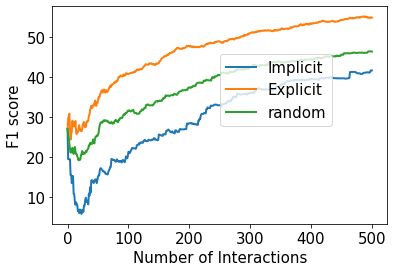

In [152]:
plt.rcParams.update({'font.size': 15})
d1["f1"].plot(linewidth=2, label="Implicit")
d2["f1"].plot(linewidth=2, label="Explicit")
d3["f1"].plot(linewidth=2, label="random")
#pd.Series([21.42]*(number_of_queries+1)).plot(linewidth=2, label="baseline")
plt.ylabel("F1 score")
plt.xlabel("Number of Interactions")
plt.legend(loc=(0.5,0.45))
#plt.savefig('f1_score3.png', bbox_inches='tight',pad_inches = 0.1, dpi = 600)

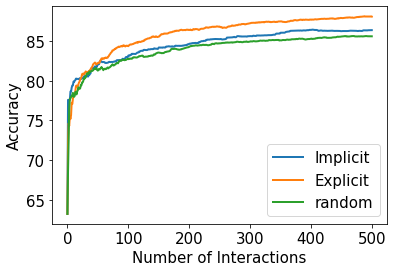

In [153]:
d1["accuracy"].plot(linewidth=2, label="Implicit")
d2["accuracy"].plot(linewidth=2, label="Explicit")
d3["accuracy"].plot(linewidth=2, label="random")
plt.ylabel("Accuracy")
plt.xlabel("Number of Interactions")
plt.legend()
#plt.savefig('accuracy3.png', bbox_inches='tight',pad_inches = 0.1, dpi = 600)

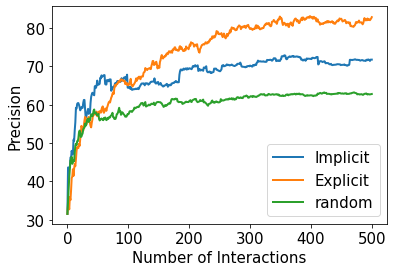

In [154]:
d1["precision"].plot(linewidth=2, label="Implicit")
d2["precision"].plot(linewidth=2, label="Explicit")
d3["precision"].plot(linewidth=2, label="random")
plt.ylabel("Precision")
plt.xlabel("Number of Interactions")
plt.legend()
#plt.savefig('precision3.png', bbox_inches='tight',pad_inches = 0.1, dpi = 600)

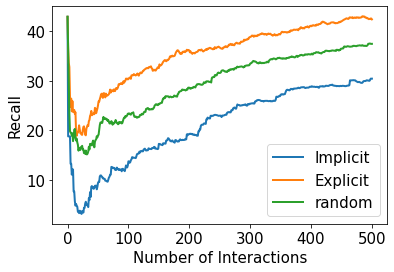

In [155]:
d1["recall"].plot(linewidth=2, label="Implicit")
d2["recall"].plot(linewidth=2, label="Explicit")
d3["recall"].plot(linewidth=2, label="random")
plt.ylabel("Recall")
plt.xlabel("Number of Interactions")
plt.legend()

In [223]:
for x,y in zip(X_lab, y_lab):
    print(x,y)

a 0
an 0
he 0
she 0
be 0
the 0
cat 0
dog 0
bat 0
mat 0
rat 0
graph 1
group 1
trivedi 1
green 1
grand 1
provost 1
crisp 1
grey 1
grill 1
crumble 1
torpor 0
dragon 1
globs 0
backgrounds 0
pioneered 0
premonition 1
scrubbed 0
prospectus 1
gravitate 1
torque 0
brother 1
screwdriver 0
bluebeard 0
granddaughters 1
blinds 0
trivialize 1
blas 0
predate 1
greenbelt 1
trends 1
carpenter 0
primarily 1
freight 1
frate 1
breakers 1
positron 0
promptly 1
carburetor 0
brainpower 1
drama 1
griscom 1
grimmest 1
predominant 1
pretending 1
lohengrin 0
sprinkler 0
transition 1
christiana 0
grossed 1
bizarre 0
profanity 1
plumbed 0
bro 1
tremors 1
shrug 0
bernhardt 0
cambrian 0
geriatric 0
quasar 0
printable 1
traitor 1
trailer 1
preschool 1
denmark 0
creature 1
breastplate 1
gravestone 1
preserving 1
ozarks 0
protruding 1
kristin 1
prophetic 1
brunet 1
brunette 1
drool 1
predators 1
groove 1
crier 1
procedures 1
protestors 1
protesters 1
cranky 1
blindness 0
darkly 0
clarke 0
clark 0
presiding 1
breeders 

In [224]:
len(X_lab), len(y_lab)

(121, 121)

In [225]:
clf.predict([lookup["BREW"]])[0]

1

In [192]:
oracle("trpor",0)

1

In [193]:
(2*0.12*1)/(1+0.12)

0.21428571428571425

In [233]:
str1 = "this7";  # No space & digit in this string
print(str1.isalpha()) # it gives return True

str2 = "this is 2";
print(str2.isalpha()) # it gives return False

False
False
